In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
# from scipy.signal import correlate
from scipy.fft import fft, fftfreq
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import IsolationForest
from scipy.interpolate import interp1d

from numpy.linalg import norm
from scipy.interpolate import interp1d

# %matplotlib notebook
import seaborn as sns

import time
# import serial
from IPython.display import clear_output

In [5]:
from sklearn.preprocessing import LabelEncoder
from scipy.ndimage import gaussian_filter1d
# from tensorflow.keras.utils import to_categorical

## Funcs

In [6]:
def plotly_sensor(df, gesture, sensor):
    '''
    Plotly график для указанного сенсора и типа жеста
    ''' 
    filtered_data = df[df.gesture == gesture][['step', sensor]]
    fig = px.line(filtered_data, x='step', y=sensor, title=f'График зависимости признака {sensor} от steps')

    fig.show()
    
def average_dict(dict_):    
    '''
    Сасчитываем  среднее для значений в словаре
    '''
    return sum(dict_.values())/len(dict_)


def plot_sensors(df, cols, range_: range):
    '''
    Отображаем в указанном диапазоне показания жедаемых сенсоров
    '''
    # range_ = range(7400,8200)
    # range_ = range(gestures.shape[0])

    fig, axes = plt.subplots(10, 5, figsize=(20, 20), sharex=True, sharey=True)

    # Преобразуем 2D массив осей в 1D массив для удобства
    axes = axes.flatten()

    for i, column in enumerate(cols):
        axes[i].plot(df[column].values[range_])
        axes[i].set_title(column)

    # Удаляем лишние подграфики, если их меньше 50
    for j in range(len(cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
    
    
def cosine_similarity(a,b):
    """
    Функция для вычисления косинусного сходства между двумя векторами.

    Косинусное сходство — это мера сходства между двумя векторами,
    которая вычисляется как косинус угла между ними. Оно показывает,
    насколько два вектора ориентированы в одном направлении.
    """    
    print(np.dot(a, b) / (norm(a) * norm(b)))

def interpolate_vector(vector, new_length):
    """
    Функция для линейной интерполяции вектора до новой длины.

    Параметры:
    vector (numpy.ndarray): Исходный вектор.
    new_length (int): Новая длина вектора.

    Возвращает:
    numpy.ndarray: Интерполированный вектор с новой длиной.
    """    
    x = np.linspace(0, 1, len(vector))
    f = interp1d(x, vector, kind='linear')
    new_x = np.linspace(0, 1, new_length)
    return f(new_x)    


def cosine_similarity_calc(vector, initial_vector, vector_length ):
    ''' 
    Вычисляем косинусное сходство между двумя векторами
    Если длины векторов не соотвествуют заданной длине, то интерполируем вектора до требуемого размера
    '''

    if len(initial_vector) != vector_length:
        initial_vector = interpolate_vector(initial_vector, vector_length)

    if len(vector) != vector_length:
        vector = interpolate_vector(vector, vector_length)
        
    return np.dot(vector,initial_vector)/ (norm(vector)*norm(initial_vector))

# IO utils


In [7]:
def read_omg_csv(path_palm_data: str, 
                 n_omg_channels: int, 
                 n_acc_channels: int = 0, 
                 n_gyr_channels: int = 0, 
                 n_mag_channels: int = 0, 
                 n_enc_channels: int = 0,
                 button_ch: bool = True, 
                 sync_ch: bool = True, 
                 timestamp_ch: bool = True) -> pd.DataFrame:
    
    '''
    Reads CSV data for OMG data
    NB: data must be separated by " " separator

        Parameters:
                path_palm_data  (str): path to csv data file
                n_omg_channels  (int): Number of OMG channels
                n_acc_channels  (int): Number of Accelerometer channels, default = 0
                n_gyr_channels  (int): Number of Gyroscope channels, default = 0
                n_mag_channels  (int): Number of Magnetometer channels, default = 0
                n_enc_channels  (int): Number of Encoder channels, default = 0
                button_ch      (bool): If button channel is present, default = True
                sync_ch        (bool): If synchronization channel is present, default = True
                timestamp_ch   (bool): If timestamp channel is present, default = True

        Returns:
                df_raw (pd.DataFrame): Parsed pandas Dataframe with OMG data
    '''
    
    df_raw = pd.read_csv(path_palm_data, sep=' ', 
                         header=None, 
                         skipfooter=1, 
                         skiprows=1, 
                         engine='python')
    columns = np.arange(n_omg_channels).astype('str').tolist()
    
    for label, label_count in zip(['ACC', 'GYR', 'MAG', 'ENC'], 
                                  [n_acc_channels, n_gyr_channels, n_mag_channels, n_enc_channels]):
        columns = columns + ['{}{}'.format(label, i) for i in range(label_count)]
        
    if button_ch:
        columns = columns + ['BUTTON']
        
    if sync_ch:
        columns = columns + ['SYNC']
        
    if timestamp_ch:
        columns = columns + ['ts']
        
    df_raw.columns = columns
    
    return df_raw

# Abbreviations
OMG — optomiography  
ACC — accelerometer  
GYR — gyroscope  
ENC - encoders (fingers of prosthesis or gloves)  
model — model of data  

# Data

In [8]:
palm_file = './data/2023-05-31_17-14-41.palm'
# palm_file = './data/2023-05-05_17-57-30.palm'
# palm_file = './data/2023-05-07_15-19-05.palm'

gestures = read_omg_csv(palm_file, 
                              n_omg_channels=50,
                              n_acc_channels=3, 
                              n_gyr_channels=3, 
                              n_enc_channels=6, 
                              n_mag_channels=0)

print(gestures.shape)
gestures.head()

(19568, 65)


0  1  2  3  4  5  6  7   8   9  ...  GYR2  ENC0  ENC1  ENC2  ENC3  ENC4  \
0  12  8  5  6  2  4  5  7  14   8  ...   -13     0     0     0     0     0   
1  13  8  4  5  3  0  5  4   9  10  ...   -16     0     0     0     0     0   
2  12  5  9  5  0  0  6  5  10   9  ...   -14     0     0     0     0     0   
3  10  7  6  4  1  0  4  6   7   8  ...   -12     0     0     0     0     0   
4  12  6  6  7  3  2  6  7   9  12  ...   -12     0     0     0     0     0   

   ENC5  BUTTON  SYNC      ts  
0     0       0     0  555777  
1     0       0     0  555810  
2     0       0     0  555843  
3     0       0     0  555876  
4     0       0     0  555909  

[5 rows x 65 columns]

In [9]:
# [X features] '0', ..., '49' - каналы OMG датчиков
#              'ACC0', 'ACC1', 'ACC2' - акселерометр (потенциально могут использоваться как факторы для модели)
#              'GYR0', 'GYR1', 'GYR2' - гироскоп     (потенциально могут использоваться как факторы для модели)
# 'BUTTON' - не используется
# 'SYNC' - синхронизация данных с протоколом
# 'ts' - метка времени
gestures.columns

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49', 'ACC0', 'ACC1', 'ACC2', 'GYR0', 'GYR1', 'GYR2', 'ENC0', 'ENC1',
       'ENC2', 'ENC3', 'ENC4', 'ENC5', 'BUTTON', 'SYNC', 'ts'],
      dtype='object')

In [10]:
OMG_CH = [str(i) for i in range(50)]

ACC_CH = ['ACC0', 'ACC1', 'ACC2']
GYR_CH = ['GYR0', 'GYR1', 'GYR2']
ENC_CH = ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH = ['BUTTON', 'SYNC', 'ts']

assert len(OMG_CH)+len(ACC_CH)+len(GYR_CH)+len(ENC_CH)+len(BUTTON_SYNC_TS_CH) == gestures.shape[-1]

print(f"OMG_CH: {list(OMG_CH)}")
print(f"ACC_CH: {list(ACC_CH)}")
print(f"GYR_CH: {list(GYR_CH)}")
print(f"ENC_CH: {list(ENC_CH)}")
print(f"BUTTON_SYNC_TS_CH: {list(BUTTON_SYNC_TS_CH)}")

OMG_CH: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49']
ACC_CH: ['ACC0', 'ACC1', 'ACC2']
GYR_CH: ['GYR0', 'GYR1', 'GYR2']
ENC_CH: ['ENC0', 'ENC1', 'ENC2', 'ENC3', 'ENC4', 'ENC5']
BUTTON_SYNC_TS_CH: ['BUTTON', 'SYNC', 'ts']


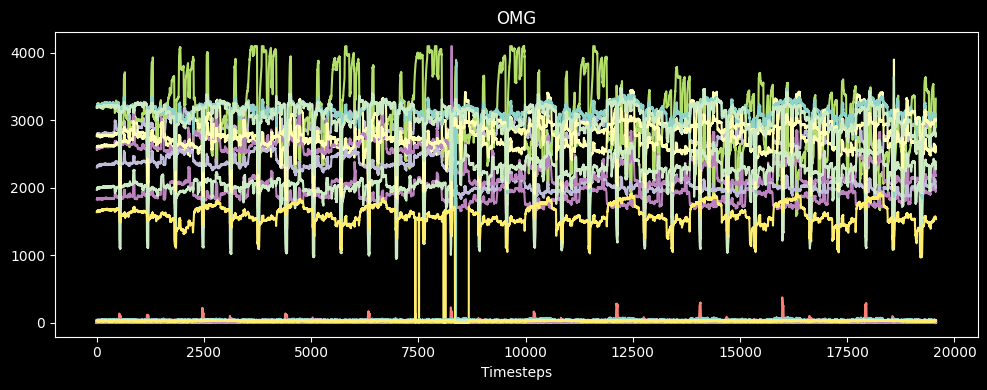

In [11]:
fig = plt.figure(figsize=(10, 4))
plt.plot(gestures[OMG_CH].values)
plt.title('OMG')
plt.xlabel('Timesteps')
plt.tight_layout()

### Protocol

In [12]:
gestures_protocol = pd.read_csv(f'{palm_file}.protocol.csv', index_col=0)
gestures_protocol.head(10)

Thumb  Index  Middle  Ring  Pinky  Thumb_stretch  Index_stretch  \
epoch                                                                    
0        0.0    0.0     0.0   0.0    0.0            0.0            0.0   
1        0.0    0.0     0.0   0.0    0.0            0.0            0.0   
2        1.0    0.0     0.0   0.0    0.0            0.0            0.0   
3        1.0    1.0     1.0   1.0    1.0            0.0            0.0   
4        0.0    0.0     0.0   0.0    0.0            1.0            1.0   
5        1.0    1.0     0.0   0.0    0.0            0.0            0.0   
6        0.0    0.0     1.0   1.0    1.0            0.0            0.0   
7        0.0    0.0     0.0   0.0    0.0            0.0            0.0   
8        1.0    0.0     0.0   0.0    0.0            0.0            0.0   
9        1.0    1.0     1.0   1.0    1.0            0.0            0.0   

       Middle_stretch  Ring_stretch  Pinky_stretch  Pronation  
epoch                                                          
0                 0.0           0.0            0.0        0.0  
1                 0.0           0.0            0.0        0.0  
2                 0.0           0.0            0.0        0.0  
3                 0.0           0.0            0.0        0.0  
4                 1.0           1.0            1.0        0.0  
5                 0.0           0.0            0.0        0.0  
6                 0.0           0.0            0.0        0.0  
7                 0.0           0.0            0.0        0.5  
8                 0.0           0.0            0.0        0.5  
9                 0.0           0.0            0.0        0.5

In [13]:
le = LabelEncoder()

# FIT
le.fit(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)

# TRANSFORM
gestures_protocol['gesture'] = le.transform(
    gestures_protocol[[
        "Thumb","Index","Middle","Ring","Pinky",
        'Thumb_stretch','Index_stretch','Middle_stretch','Ring_stretch','Pinky_stretch'
    ]]
    .apply(lambda row: str(tuple(row)), axis=1)
)
    
display(np.c_[le.transform(le.classes_), le.classes_])

array([[0, '(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [1, '(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0)'],
       [2, '(0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [3, '(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [4, '(1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)'],
       [5, '(1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0)']],
      dtype=object)

In [14]:
GESTURES = ['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']
GESTURES

['Neutral', 'Open', 'Pistol', 'Thumb', 'OK', 'Grab']

In [15]:
y_cmd = np.array([gestures_protocol['gesture'].loc[s] for s in gestures['SYNC'].values])
y_cmd

array([0, 0, 0, ..., 0, 0, 0])


8, 12, 16, 17, 21, 22, 26, 27, 28, 29, 30, 31, 32, 36, 37, 38, 39, 40, 41, 42, 43, 46, 47, 48, 49

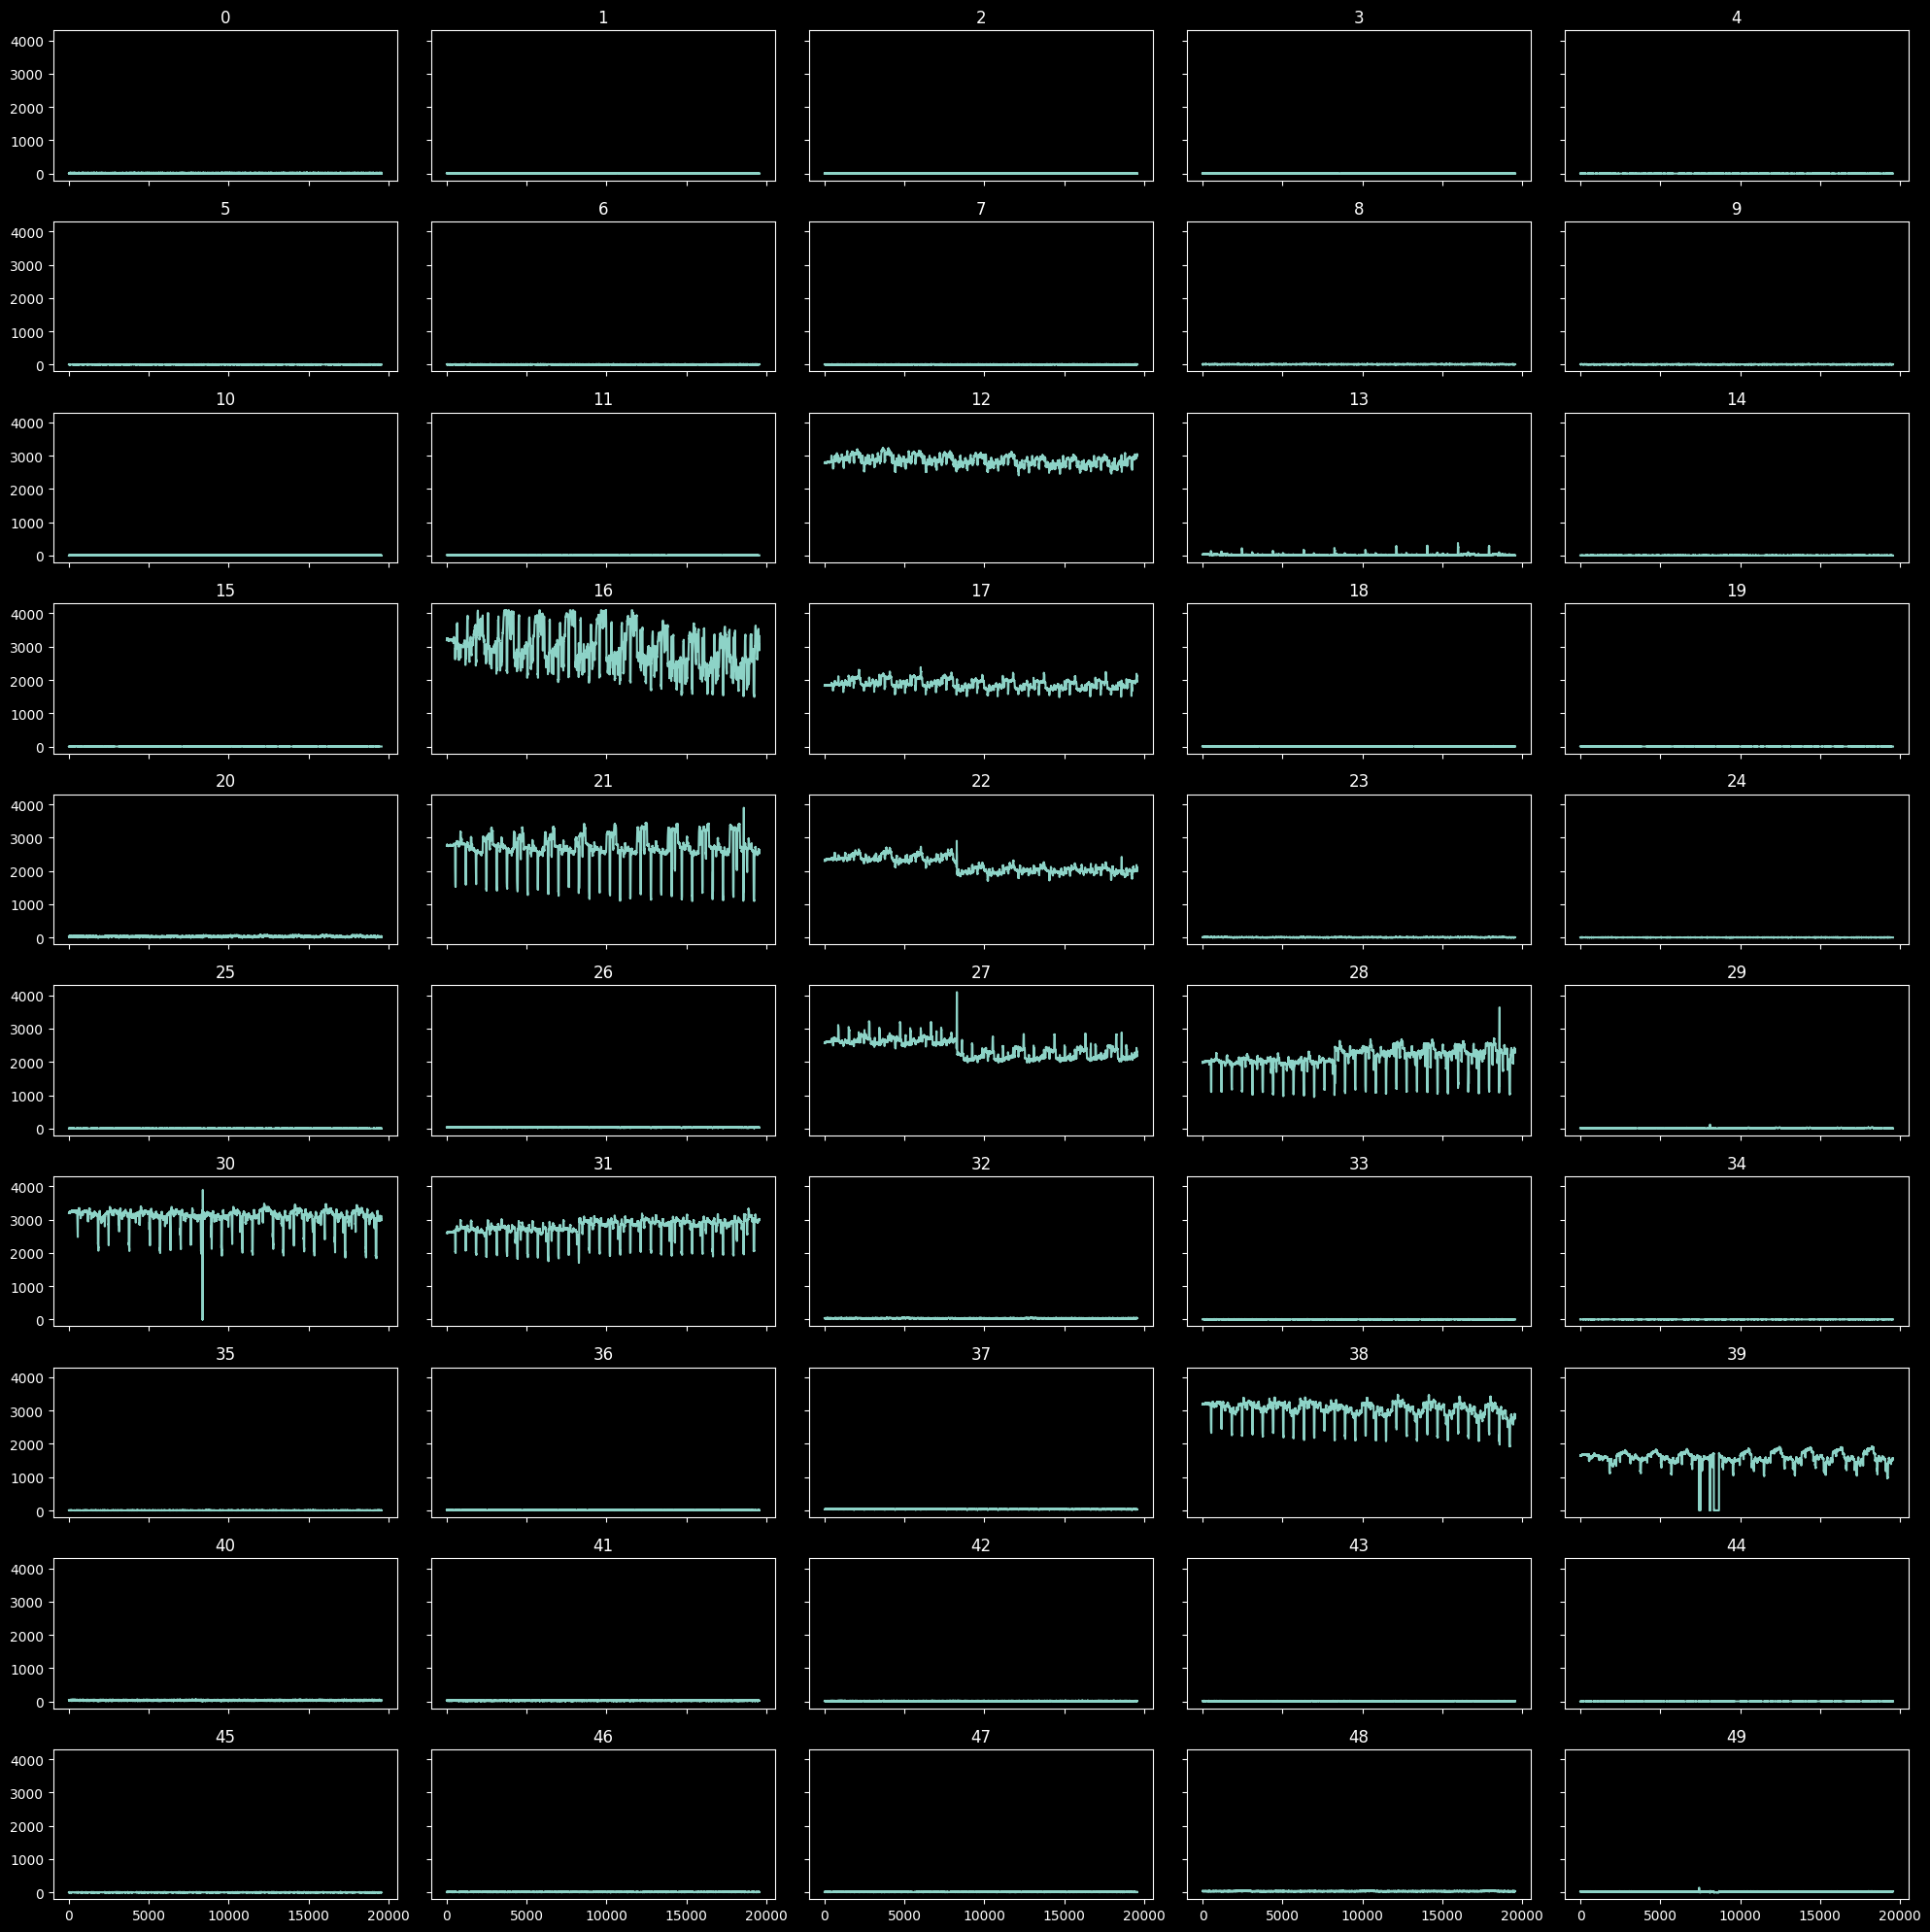

In [16]:
plot_sensors(gestures, OMG_CH, range(gestures.shape[0]))

In [17]:
df = gestures.copy()

In [18]:
# Добавим новый признак - шаг, который характеризует нахождение набора данных в определенном состоянии (grab, ok и т.д)
# Нам это нужно, чтобы точно знать сегменты, для определения паттерна поведения. В текущий момент признак SYNC для нейтрального состояния общий для всех шагов, что не дает нам понимания о нахождении на временной прямой
df['step'] = (df['SYNC'] != df['SYNC'].shift(1)).cumsum()

df.step.value_counts()

step
1      288
23      69
207     62
199     62
189     62
      ... 
208     45
206     45
2       45
24      39
361     27
Name: count, Length: 361, dtype: int64

In [19]:
# Добавим в текущий датафрэйм также информацию о жестах, чтобы в будущем удобно убрать временную задержку выполнения жеста 
df = pd.merge(df, gestures_protocol['gesture'], how = 'inner', left_on='SYNC', right_index=True)

In [20]:
df

0  1  2  3  4  5  6  7   8   9  ...  ENC1  ENC2  ENC3  ENC4  ENC5  \
0      12  8  5  6  2  4  5  7  14   8  ...     0     0     0     0     0   
1      13  8  4  5  3  0  5  4   9  10  ...     0     0     0     0     0   
2      12  5  9  5  0  0  6  5  10   9  ...     0     0     0     0     0   
3      10  7  6  4  1  0  4  6   7   8  ...     0     0     0     0     0   
4      12  6  6  7  3  2  6  7   9  12  ...     0     0     0     0     0   
...    .. .. .. .. .. .. .. ..  ..  ..  ...   ...   ...   ...   ...   ...   
19563   3  6  7  4  2  0  6  3  13   8  ...     0     0     0     0     0   
19564  26  6  5  3  2  1  4  4   9   7  ...     0     0     0     0     0   
19565  14  7  6  4  2  0  6  5  13   8  ...     0     0     0     0     0   
19566  30  6  6  4  2  0  5  5  10   6  ...     0     0     0     0     0   
19567  11  6  6  4  2  1  5  5  11   7  ...     0     0     0     0     0   

       BUTTON  SYNC       ts  step  gesture  
0           0     0   555777     1        0  
1           0     0   555810     1        0  
2           0     0   555843     1        0  
3           0     0   555876     1        0  
4           0     0   555909     1        0  
...       ...   ...      ...   ...      ...  
19563       0     0  1201356   361        0  
19564       0     0  1201389   361        0  
19565       0     0  1201422   361        0  
19566       0     0  1201455   361        0  
19567       0     0  1201488   361        0  

[19568 rows x 67 columns]

In [21]:
def steps_getter(df, sensor, gesture):
    '''
    Получаем список шагов для указанного сенсора и жеста
    Т.е например. У нас в датасете есть жест 3, и мы хотим получить список шагов, где он присутствует. например Шаги [8, 12,34]
    
    '''
    return df[df.gesture == gesture][[sensor,'step']].step.unique()

def vector_getter(df, sensor, gesture, steps):
    '''
    Возращаем векторы в словаре для указанных шагов
    '''
    v = {}
    for step in steps:
        v[step] = df[(df.gesture == gesture)  & (df.step == step) ][sensor].to_numpy().T
    return v

def calc_mean_cos_for_vector(df, sensor, gesture, steps, vectors):
    v_cos_sum = {}
    for step in steps:
        vector = df[(df.gesture == gesture)  & (df.step == step) ][sensor].to_numpy().T
        vector_sum = np.array([])
        max_length = max(len(el) for el in vectors.values())
        for vector_comp in vectors.values():
            vector_sum = np.append(vector_sum, cosine_similarity_calc(vector_comp, vector, max_length))
        v_cos_sum[step] = (vector_sum.mean())    
    return v_cos_sum    


def vectors_cousine(df):
    '''
        Расчитываем косинусную схожесть путем пересчета ее для всех векторов одинакового шага и жеста, и получаем сумму их
        Т.е например 1 шаг это жест 2, там 30 векторов. Расчет будет произведен каждого вектора со всеми другими в этом списке. Т.е. 30 x 30 = 900 значений.
        
        vectors_all - все вектора, не включая нейтральную позицию
        vectors_sum_all - суммы косинусов между текущим векторам и всеми остальными в данном канале по каждому жесту канал, жест, шаги
    '''    
    vectors_sum_all = {}
    vectors_all = {}
    
    for column in range(0,50):
        vectors_sum_all[column] = {}
        vectors_all[column] = {}
        for gesture in range(1,6):
            steps_ = steps_getter(df, str(column), gesture)
            vectors_= vector_getter(df, str(column), gesture, steps_)
            vectors_all[column][gesture] = vectors_
            vectors_sum_all[column][gesture] = calc_mean_cos_for_vector(df, str(column), gesture, steps_, vectors_)
    return vectors_all, vectors_sum_all      

Для нейтрального положения рассчитывать будем иначе, так как их очень много и расчет будет долгий. Так что сейчас только для жестов.

In [22]:
vectors,vectors_sum = vectors_cousine(df)

In [23]:
# 49 Сенсор, 1 жест, все вектора
vectors[49][1]

{8: array([26, 27, 28, 28, 27, 26, 25, 27, 28, 28, 28, 24, 28, 28, 29, 26, 30,
        25, 24, 27, 28, 31, 29, 20, 28, 24, 25, 25, 26, 25, 30, 26, 25, 26,
        28, 25, 26, 29, 26, 25, 28, 28, 38, 26, 30, 26], dtype=int64),
 20: array([28, 24, 23, 28, 27, 29, 25, 29, 29, 25, 25, 31, 30, 21, 27, 29, 28,
        28, 25, 25, 30, 28, 26, 25, 26, 28, 28, 25, 27, 25, 26, 25, 24, 27,
        29, 24, 27, 25, 30, 31, 27, 28, 25, 30, 26, 30], dtype=int64),
 32: array([26, 30, 29, 26, 27, 29, 29, 28, 28, 28, 25, 28, 28, 32, 27, 26, 29,
        29, 28, 25, 28, 24, 27, 27, 28, 26, 27, 24, 25, 28, 27, 26, 28, 29,
        25, 27, 26, 26, 25, 29, 26, 28, 29, 28, 28, 30], dtype=int64),
 44: array([26, 32, 30, 31, 25, 32, 30, 31, 32, 32, 31, 29, 32, 28, 29, 29, 29,
        25, 29, 31, 28, 27, 28, 30, 32, 28, 32, 30, 27, 30, 25, 30, 32, 29,
        29, 33, 30, 29, 29, 29, 30, 29, 29, 33, 29, 28], dtype=int64),
 56: array([32, 27, 28, 29, 28, 30, 32, 32, 27, 32, 31, 27, 30, 31, 30, 32, 32,
        30, 2

In [24]:
# рассчитаем среднее значение по все векторам жестов по сенсору
# Идея в этом, что если у нас есть повторяющийся паттерн для жеста, то и косинусное сходство высокое. Если оно низкое, то у нас наблюдается высокий шум, и такие данные надо выброить из измерения, так как они не дают нам четкой картины
range_start = 1
range_end = 6
gesture_count = range_end-range_start

sensor_mean = {}

for idx, sensor in enumerate(vectors_sum.values()):
    sum_ = 0
    for gesture in range(1,6):
        sum_average = average_dict(sensor[gesture])
        sum_ = sum_+sum_average
    sensor_mean[idx] = sum_/gesture_count

In [25]:
sensor_mean

{0: 0.8477447316464193,
 1: 0.924815080925384,
 2: 0.8869061207458385,
 3: 0.8752313625605239,
 4: 0.7596191040880504,
 5: 0.5193778124401993,
 6: 0.9041283632584737,
 7: 0.8812005874575959,
 8: 0.965260955588643,
 9: 0.9568112794696125,
 10: 0.5554681716979799,
 11: 0.9393179554710203,
 12: 0.9997973607309103,
 13: 0.9125081850050144,
 14: 0.9140473796784565,
 15: 0.5742218953356532,
 16: 0.995037061710601,
 17: 0.999490554007143,
 18: 0.9073816059195383,
 19: 0.6710062571629749,
 20: 0.9549985368634332,
 21: 0.9978929517676425,
 22: 0.9997608609530639,
 23: 0.9143167564062672,
 24: 0.8012914779167678,
 25: 0.5970072347783825,
 26: 0.9936005783987936,
 27: 0.9993686235840196,
 28: 0.998231976039467,
 29: 0.962817082441736,
 30: 0.9945710059304368,
 31: 0.9993430095924432,
 32: 0.9955726030415969,
 33: 0.880659137752629,
 34: 0.8110223346404533,
 35: 0.609725024723613,
 36: 0.9695840793250994,
 37: 0.9962493281436402,
 38: 0.9997014174696014,
 39: 0.989310593602349,
 40: 0.981056955726

In [26]:
# Выберем сенсоры, где показатель суммы косинусного сходства больше 0.95
CLEAN_SENSORS = list({str(k): v for k, v in sensor_mean.items() if v > 0.95}.keys())
print(CLEAN_SENSORS)
# Это те каналы, где паттерн значений повторяемый более менее

['8', '9', '12', '16', '17', '20', '21', '22', '26', '27', '28', '29', '30', '31', '32', '36', '37', '38', '39', '40', '41', '42', '43', '46', '47', '48', '49']


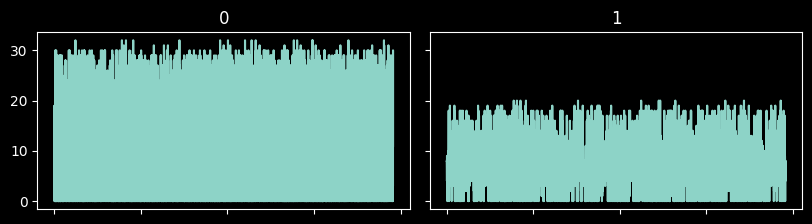

In [27]:
# Посмотрим например пару каналов, который не попали
plot_sensors(gestures, ['0','1'], range(gestures.shape[0]))

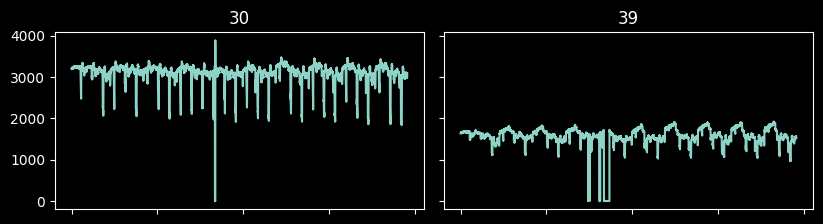

In [28]:
# Посмотрим например пару каналов, который попали
plot_sensors(gestures, ['30','39'], range(gestures.shape[0]))

Как видно, даже с выбросами, мы имеем каналы, которые имеют повторяемый паттерн, в отличии от каналов, больше похожих на шум


12,16,17,21,22,27,28,30,31,38,39

Учитывая что мы работаем с оптодатчиками и измерениями на одном участке тела, то в моем понимании, сила сигнала должна быть более менее на одном уровне, т.е если один датчик выдает 3000, то остальные будут в похожем диапазоне +/-.

В нашем же случае мы имеем на одних дачиках 4000, на других 20. Учитывая чувствительность и склонность к шумам, то думаю что слабые сигналы можем также убрать, так как даже с наличием паттерна, толка они не внесут. Опять же, всегда можем вернутья и доизучить их


In [30]:
# Проверим медианные занчения по сенсорам из ранее выбранных признаков
df_median  = pd.DataFrame(df[CLEAN_SENSORS].median(), columns=['median_value']).rename_axis('sensor_id')
# Чтобы грубо автоматизировать процесс выбор сильных сигналов
max_sensor = df_median.max().iloc[0]
print(f'Мксимальная сила сигнала: {max_sensor}')
# Рассчитаем процент силы сигнала для каждого сенсора, относительно максимального
df_median['percent'] = (df_median['median_value']/max_sensor * 100).round(2)

def highlight_red(s, below_level):
    ''' 
      Подкрасим для удобства визуализации все сенсоры, которые имеют сигнал  слабее 25% от макисмального сигнала   
    '''
    styles = []
    for v in s:
        if v < below_level:
            styles.append('color: red; background-color: lightyellow; font-weight: bold;')
        else:
            styles.append('')
    return styles

df_to_style = df_median[['percent']]
df_to_style.style.apply(highlight_red, below_level=25, subset=['percent'], axis=1)



Мксимальная сила сигнала: 3149.0


In [31]:
# Получим список сильных признаков
CLEAN_SENSORS_FINAL = list(df_median[df_median.percent > 25].percent.index)
CLEAN_SENSORS_FINAL


['12', '16', '17', '21', '22', '27', '28', '30', '31', '38', '39']

In [32]:
# Получим список векторов для сенсоров из сенсоров в итоге выбраных для каждого жеста/шага
vectors_final = {key: vectors[key] for key in [int(id) for id in CLEAN_SENSORS_FINAL] if key in vectors}


In [33]:
# например 12 сенсор/5 жест/6 шаг
vectors_final[12][5][6]

array([2843, 2858, 2852, 2855, 2849, 2838, 2851, 2850, 2853, 2845, 2852,
       2847, 2855, 2854, 2855, 2853, 2844, 2818, 2787, 2732, 2715, 2699,
       2649, 2627, 2627, 2631, 2628, 2614, 2611, 2612, 2633, 2664, 2690,
       2715, 2724, 2732, 2736, 2738, 2739, 2739, 2738, 2729, 2721, 2712,
       2714, 2708], dtype=int64)

In [34]:
df_clean = df[CLEAN_SENSORS_FINAL + ['step','SYNC','gesture','ts']]
df_clean.head()

12    16    17    21    22    27    28    30    31    38    39  step  \
0  2783  3193  1827  2763  2299  2562  1969  3199  2597  3184  1639     1   
1  2794  3201  1833  2771  2316  2572  1981  3216  2604  3196  1650     1   
2  2795  3210  1837  2766  2312  2563  1973  3199  2600  3184  1641     1   
3  2796  3221  1839  2773  2322  2574  1986  3216  2610  3199  1651     1   
4  2795  3228  1838  2775  2323  2576  1990  3207  2603  3191  1645     1   

   SYNC  gesture      ts  
0     0        0  555777  
1     0        0  555810  
2     0        0  555843  
3     0        0  555876  
4     0        0  555909

In [35]:
# Соберем все нейтральные вектора
vectors_neutral = {}

for column in CLEAN_SENSORS_FINAL:

    vectors_neutral[column] = {}
    for gesture in range(0,1):
        steps_ = steps_getter(df_clean, str(column), gesture)
        vectors_= vector_getter(df_clean, str(column), gesture, steps_)
        vectors_neutral[column][gesture] = vectors_


In [36]:
# Расчитаем медианную длину вектора для нейтральной позиции
# Тут можем за расчет взять любой признак из выбранных. берем 0-ой, так как он точно всегда будет
lengths = [len(v) for v in vectors_neutral[CLEAN_SENSORS_FINAL[0]][0].values()]
median_length = int(np.median(lengths))
print(f'Длина медианного вектора для нейтральной позиции: {median_length}')

Длина медианного вектора для нейтральной позиции: 61


In [37]:
# Получим медианные вектора для каждого сенсора из выбранных
median_neutral_vector = {}
# Получим шаговое изменение между элементами медаинного вектора  для каждого сенсора из выбранных
median_neutral_vector_diff = {}

for column in CLEAN_SENSORS_FINAL:
    # Интерполируем все массивы до одной длины
    interpolated_arrays = []
    for array in vectors_neutral[column][0].values():
        x = np.linspace(0, 1, len(array))
        f = interp1d(x, array, kind='linear', fill_value='extrapolate')
        new_x = np.linspace(0, 1, median_length)
        interpolated_arrays.append(f(new_x))

    matrix = np.stack(interpolated_arrays)

    # Вычисляем медианный вектор
    median_vector = np.median(matrix, axis=0)
    median_neutral_vector[column] = median_vector
    median_neutral_vector_diff[column] = np.diff(median_vector)


In [38]:
# Получим медианные вектора для каждого сенсора из выбранных
median_vector_all = {}
# Получим шаговое изменение между элементами медаинного вектора  для каждого сенсора из выбранных
median_vector_diff = {}

for column in CLEAN_SENSORS_FINAL:
    # Интерполируем все массивы до одной длины
    interpolated_arrays = []
    median_vector_all[column] = {}
    median_vector_diff[column] = {}
    
    for array in vectors_neutral[column][0].values():
        x = np.linspace(0, 1, len(array))
        f = interp1d(x, array, kind='linear', fill_value='extrapolate')
        new_x = np.linspace(0, 1, median_length)
        interpolated_arrays.append(f(new_x))

    matrix = np.stack(interpolated_arrays)

    # Вычисляем медианный вектор
    median_vector = np.median(matrix, axis=0)
    median_vector_all[column][0] = median_vector
    median_vector_diff[column][0] = np.diff(median_vector)
    
    
    for gesture in range(1,6):
        for array in vectors_final[int(column)][gesture].values():
            x = np.linspace(0, 1, len(array))
            f = interp1d(x, array, kind='linear', fill_value='extrapolate')
            new_x = np.linspace(0, 1, median_length)
            interpolated_arrays.append(f(new_x))

        matrix = np.stack(interpolated_arrays)

        # Вычисляем медианный вектор
        median_vector = np.median(matrix, axis=0)
        median_vector_all[column][gesture] = median_vector
        median_vector_diff[column][gesture] = np.diff(median_vector)         
    

In [39]:
print(median_vector_all['39'][0])
print(vectors_neutral['39'][0][135])

[1588.         1585.8        1589.         1585.7        1588.53333333
 1587.         1591.         1589.         1589.         1587.2
 1586.33333333 1581.33333333 1584.8        1578.         1580.
 1579.         1578.         1577.         1572.         1574.
 1574.33333333 1576.         1573.         1570.         1570.
 1573.33333333 1575.46666667 1572.4        1575.         1577.
 1574.5        1573.         1573.4        1572.25       1571.23333333
 1572.         1572.         1576.         1572.         1575.
 1576.         1572.         1577.         1578.13333333 1571.
 1575.         1579.         1579.         1578.6        1581.
 1577.66666667 1582.         1580.         1580.81666667 1579.
 1582.         1586.         1578.95       1578.         1579.5
 1581.        ]
[   0    1 1552 1554 1553 1554 1553 1554 1548 1547 1550 1539 1546 1541
 1549 1548 1540 1549 1547 1540 1540 1549 1551 1550 1550 1553 1552 1554
 1552 1543 1555 1549 1548 1540 1546 1538 1537 1540 1539 1549 1540 15

In [40]:
vectors_neutral['39'][0][134]

array([1631, 1622, 1630, 1621, 1631, 1624, 1631, 1632, 1624, 1633, 1622,
       1627, 1633, 1634, 1629, 1638, 1630, 1638, 1637, 1628, 1632, 1628,
       1612, 1616, 1610, 1607, 1584, 1582, 1586, 1581, 1561, 1574, 1570,
       1559, 1568, 1557, 1566, 1567, 1556, 1566, 1567, 1566, 1555, 1553,
       1558, 1558, 1553, 1553, 1546, 1553, 1553, 1547, 1552, 1551, 1552,
       1540, 1552,    2], dtype=int64)

In [42]:
def correct_vector(new_vector, median_vector, threshold=0.2):
    corrected_vector = []
    corrected_vector_idx = []
    median_vector = interpolate_vector(median_vector,len(new_vector))
    for i, v in enumerate(new_vector):
        expected_value = median_vector[i]
        min_value = expected_value * (1 - threshold)  # -20%
        max_value = expected_value * (1 + threshold)  # +20%
        
        if v < min_value or v > max_value:
            corrected_vector.append(expected_value)  # Корректируем
            corrected_vector_idx.append(True)
        else:
            corrected_vector.append(v)  # Оставляем как есть
            corrected_vector_idx.append(False)
    return np.array(corrected_vector), corrected_vector_idx



In [43]:
# Корректируем значения нового вектора
corrected_vector, corrected_vector_idx = correct_vector(vectors_neutral['39'][0][135], median_vector_all['39'][0])
print("Корректированный вектор:", corrected_vector)


Корректированный вектор: [1588.  1586.6 1552.  1554.  1553.  1554.  1553.  1554.  1548.  1547.
 1550.  1539.  1546.  1541.  1549.  1548.  1540.  1549.  1547.  1540.
 1540.  1549.  1551.  1550.  1550.  1553.  1552.  1554.  1552.  1543.
 1555.  1549.  1548.  1540.  1546.  1538.  1537.  1540.  1539.  1549.
 1540.  1550.  1540.  1549.  1542.  1551.  1550.  1544.  1552. ]


In [44]:
def correct_vector_accordingly(vector, vector_idx, vector_diff):
    vector_ = vector.copy()
    vector_diff = interpolate_vector(vector_diff, len(vector_))
    flag_ = False
    to_change = []
    for idx, cor_vec in enumerate(vector_idx):
        if (cor_vec): 
          if idx == len(vector_idx) - 1:
                to_change.append(idx)
                for el in to_change:
                    vector_[el] = vector_[el-1]+vector_diff[el-1]
          else:
              if (flag_== False): 
                    to_change.append(idx)
                    flag_ = True
                    continue
              if flag_:
                to_change.append(idx)
                continue
        if (cor_vec==False) & (flag_== True):
            flag_ = False
            for el in to_change[::-1]:
                vector_[el] = vector_[el+1]+vector_diff[el+1]
            to_change = [] 
    return vector_              
                

In [45]:
def vector_corretion_assemly(vector, median_vector, median_vector_diff):
    corrected_vector, corrected_vector_idx = correct_vector(vector, median_vector)
    return correct_vector_accordingly(corrected_vector, corrected_vector_idx, median_vector_diff)

In [46]:
median_vector_diff['39'][0]

array([-2.2       ,  3.2       , -3.3       ,  2.83333333, -1.53333333,
        4.        , -2.        ,  0.        , -1.8       , -0.86666667,
       -5.        ,  3.46666667, -6.8       ,  2.        , -1.        ,
       -1.        , -1.        , -5.        ,  2.        ,  0.33333333,
        1.66666667, -3.        , -3.        ,  0.        ,  3.33333333,
        2.13333333, -3.06666667,  2.6       ,  2.        , -2.5       ,
       -1.5       ,  0.4       , -1.15      , -1.01666667,  0.76666667,
        0.        ,  4.        , -4.        ,  3.        ,  1.        ,
       -4.        ,  5.        ,  1.13333333, -7.13333333,  4.        ,
        4.        ,  0.        , -0.4       ,  2.4       , -3.33333333,
        4.33333333, -2.        ,  0.81666667, -1.81666667,  3.        ,
        4.        , -7.05      , -0.95      ,  1.5       ,  1.5       ])

In [47]:
post_corrected_vector = correct_vector_accordingly(corrected_vector, corrected_vector_idx, median_vector_diff['39'][0])
post_corrected_vector

array([1553.22152778, 1551.51111111, 1552.        , 1554.        ,
       1553.        , 1554.        , 1553.        , 1554.        ,
       1548.        , 1547.        , 1550.        , 1539.        ,
       1546.        , 1541.        , 1549.        , 1548.        ,
       1540.        , 1549.        , 1547.        , 1540.        ,
       1540.        , 1549.        , 1551.        , 1550.        ,
       1550.        , 1553.        , 1552.        , 1554.        ,
       1552.        , 1543.        , 1555.        , 1549.        ,
       1548.        , 1540.        , 1546.        , 1538.        ,
       1537.        , 1540.        , 1539.        , 1549.        ,
       1540.        , 1550.        , 1540.        , 1549.        ,
       1542.        , 1551.        , 1550.        , 1544.        ,
       1552.        ])

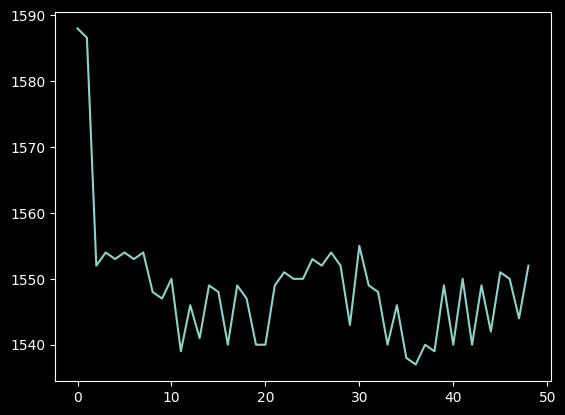

In [48]:
plt.plot(corrected_vector)

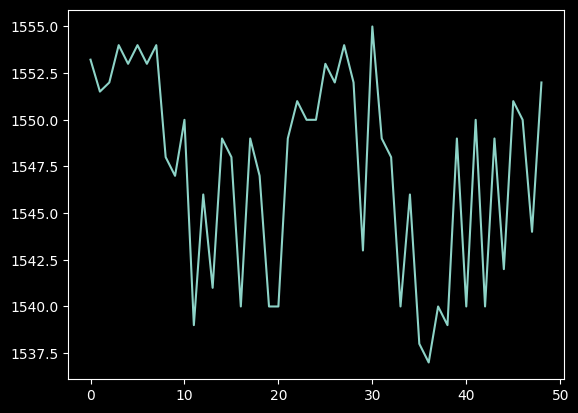

In [49]:
plt.plot(post_corrected_vector)

In [50]:
# Поиск сильных отклонений векторов по методу косинусной схожести
# не использую это пока
for col in CLEAN_SENSORS_FINAL:
    neutral_cos_calculation = {key: cosine_similarity_calc(vec, median_vector, median_length) for key, vec in vectors_neutral[col][0].items()}
    print(col, list({str(k): v for k, v in neutral_cos_calculation.items() if v < 0.90}.keys()))

12 []
16 []
17 []
21 []
22 []
27 []
28 []
30 []
31 []
38 []
39 ['147', '153', '155', '158']


In [51]:
median_vector_all['12'][0]

array([2876.        , 2871.01666667, 2871.96666667, 2871.15      ,
       2873.        , 2870.        , 2870.        , 2870.        ,
       2863.        , 2868.        , 2867.        , 2860.        ,
       2853.        , 2845.        , 2840.5       , 2836.        ,
       2831.        , 2829.        , 2824.        , 2817.        ,
       2814.66666667, 2814.        , 2812.        , 2812.85      ,
       2813.        , 2812.91666667, 2815.        , 2811.        ,
       2813.        , 2818.86666667, 2818.        , 2819.51666667,
       2821.        , 2822.        , 2820.13333333, 2820.        ,
       2821.        , 2822.23333333, 2818.        , 2822.        ,
       2819.        , 2822.5       , 2820.9       , 2822.        ,
       2822.        , 2820.        , 2822.        , 2826.        ,
       2822.8       , 2823.        , 2824.        , 2822.        ,
       2822.        , 2824.        , 2820.5       , 2823.58333333,
       2818.46666667, 2819.25      , 2819.16666667, 2818.     

In [52]:
# Получим min max по сенсорам для нейтрального положения на базе медианного вектора нейтрального положения
min_max_neutral = {}
for col in CLEAN_SENSORS_FINAL:
    min_max_neutral[col] = {}
    for gesture in range(0,6):
        min_max_neutral[col][gesture] = {'min': min(median_vector_all[col][gesture]), 'max': max(median_vector_all[col][gesture]) }
    

In [53]:
min_max_neutral['39'][1]

{'min': 1563.0, 'max': 1588.0}

In [54]:
sensor = '39'
index = 1
for idx, item in vectors_final[int(sensor)][index].items():
    outliers = [x for x in item if x > (min_max_neutral[sensor][index]['max'])*1.5 or x < (min_max_neutral[sensor][index]['min'])/1.5]
    if outliers:
        print(idx, outliers)

152 [2, 1, 1, 2, 1, 1, 2, 1, 2, 6, 1, 2, 2, 1, 2, 1, 1, 2, 1, 1, 2, 2, 2, 2, 2, 1, 1, 1, 2, 2, 1]


In [55]:
sensor = '39'
id = 1
idx = 152
print(vectors_final[int(sensor)][id][idx])
vector_corretion_assemly(vectors_final[int(sensor)][id][idx], median_vector_all[sensor][0],median_vector_diff[sensor][id]).astype('int64')

[1710 1709 1699 1697 1704 1704 1696 1706 1706 1709 1701 1701 1708 1696
 1688    2    1    1    2    1    1    2    1    2    6    1    2    2
    1    2    1    1    2    1    1    2    2    2    2    2    1    1
    1    2    2    1]


array([1710, 1709, 1699, 1697, 1704, 1704, 1696, 1706, 1706, 1709, 1701,
       1701, 1708, 1696, 1688, 1688, 1690, 1689, 1693, 1695, 1697, 1696,
       1697, 1696, 1694, 1694, 1695, 1697, 1697, 1699, 1697, 1699, 1700,
       1701, 1700, 1700, 1701, 1702, 1703, 1701, 1703, 1701, 1703, 1703,
       1702, 1700], dtype=int64)

In [56]:
plotly_sensor(df_clean, 1, '39')

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [57]:
# Выправим шаблон поведения сигнала для выбранных сенсоров для нейтральной позиции
for sensor in CLEAN_SENSORS_FINAL:
    for idx, item in vectors_neutral[sensor][0].items():
        outliers = [x for x in item if x > (min_max_neutral[sensor][0]['max'])*1.5 or x < (min_max_neutral[sensor][0]['min'])/1.5]
        if outliers:
            df_clean.loc[df_clean.step == idx, sensor] = vector_corretion_assemly(vectors_neutral[sensor][0][idx], median_vector_all[sensor][0],median_vector_diff[sensor][0]).astype('int64')
    for gesture in range(1,6):
        for idx, item in vectors_final[int(sensor)][gesture].items():
            outliers = [x for x in item if x > (min_max_neutral[sensor][gesture]['max'])*1.5 or x < (min_max_neutral[sensor][gesture]['min'])/1.5]
            if outliers:
                df_clean.loc[df_clean.step == idx, sensor] = vector_corretion_assemly(vectors_final[int(sensor)][gesture][idx], median_vector_all[sensor][gesture],median_vector_diff[sensor][gesture]).astype('int64')
        

In [ ]:
plotly_sensor(df_clean, 2, '39')

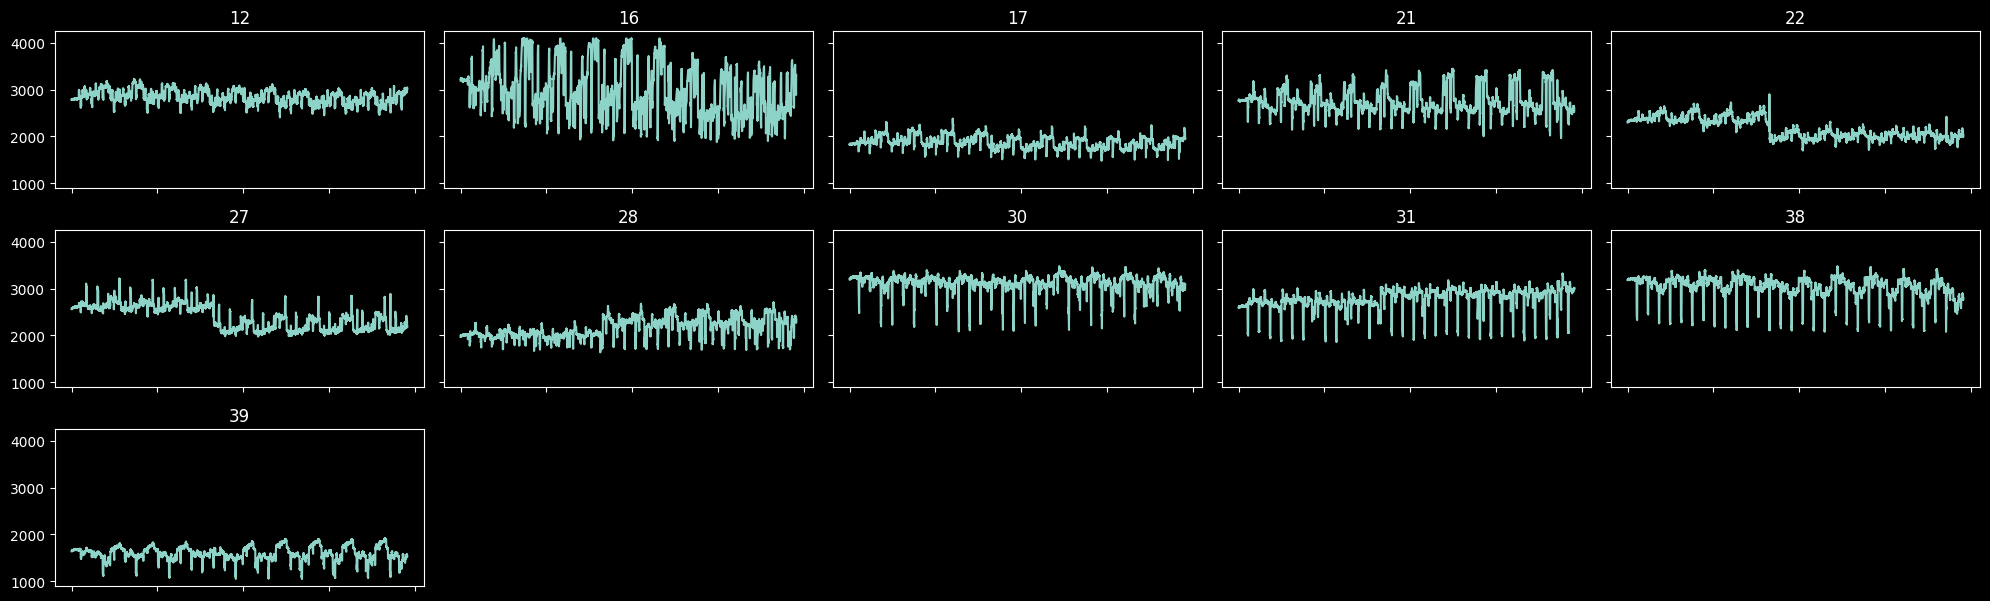

In [58]:
plot_sensors(df_clean, CLEAN_SENSORS_FINAL, range(df_clean.shape[0]))

In [59]:
# Добавляем рзницу изменений всех сенсоров суммарно по сравнению с предыдущим шагом измерений

diff = df_clean[CLEAN_SENSORS_FINAL].diff().abs()
df_clean['diff'] = diff.sum(axis=1)

C:\Users\Andrew\AppData\Local\Temp\ipykernel_26732\1189552139.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



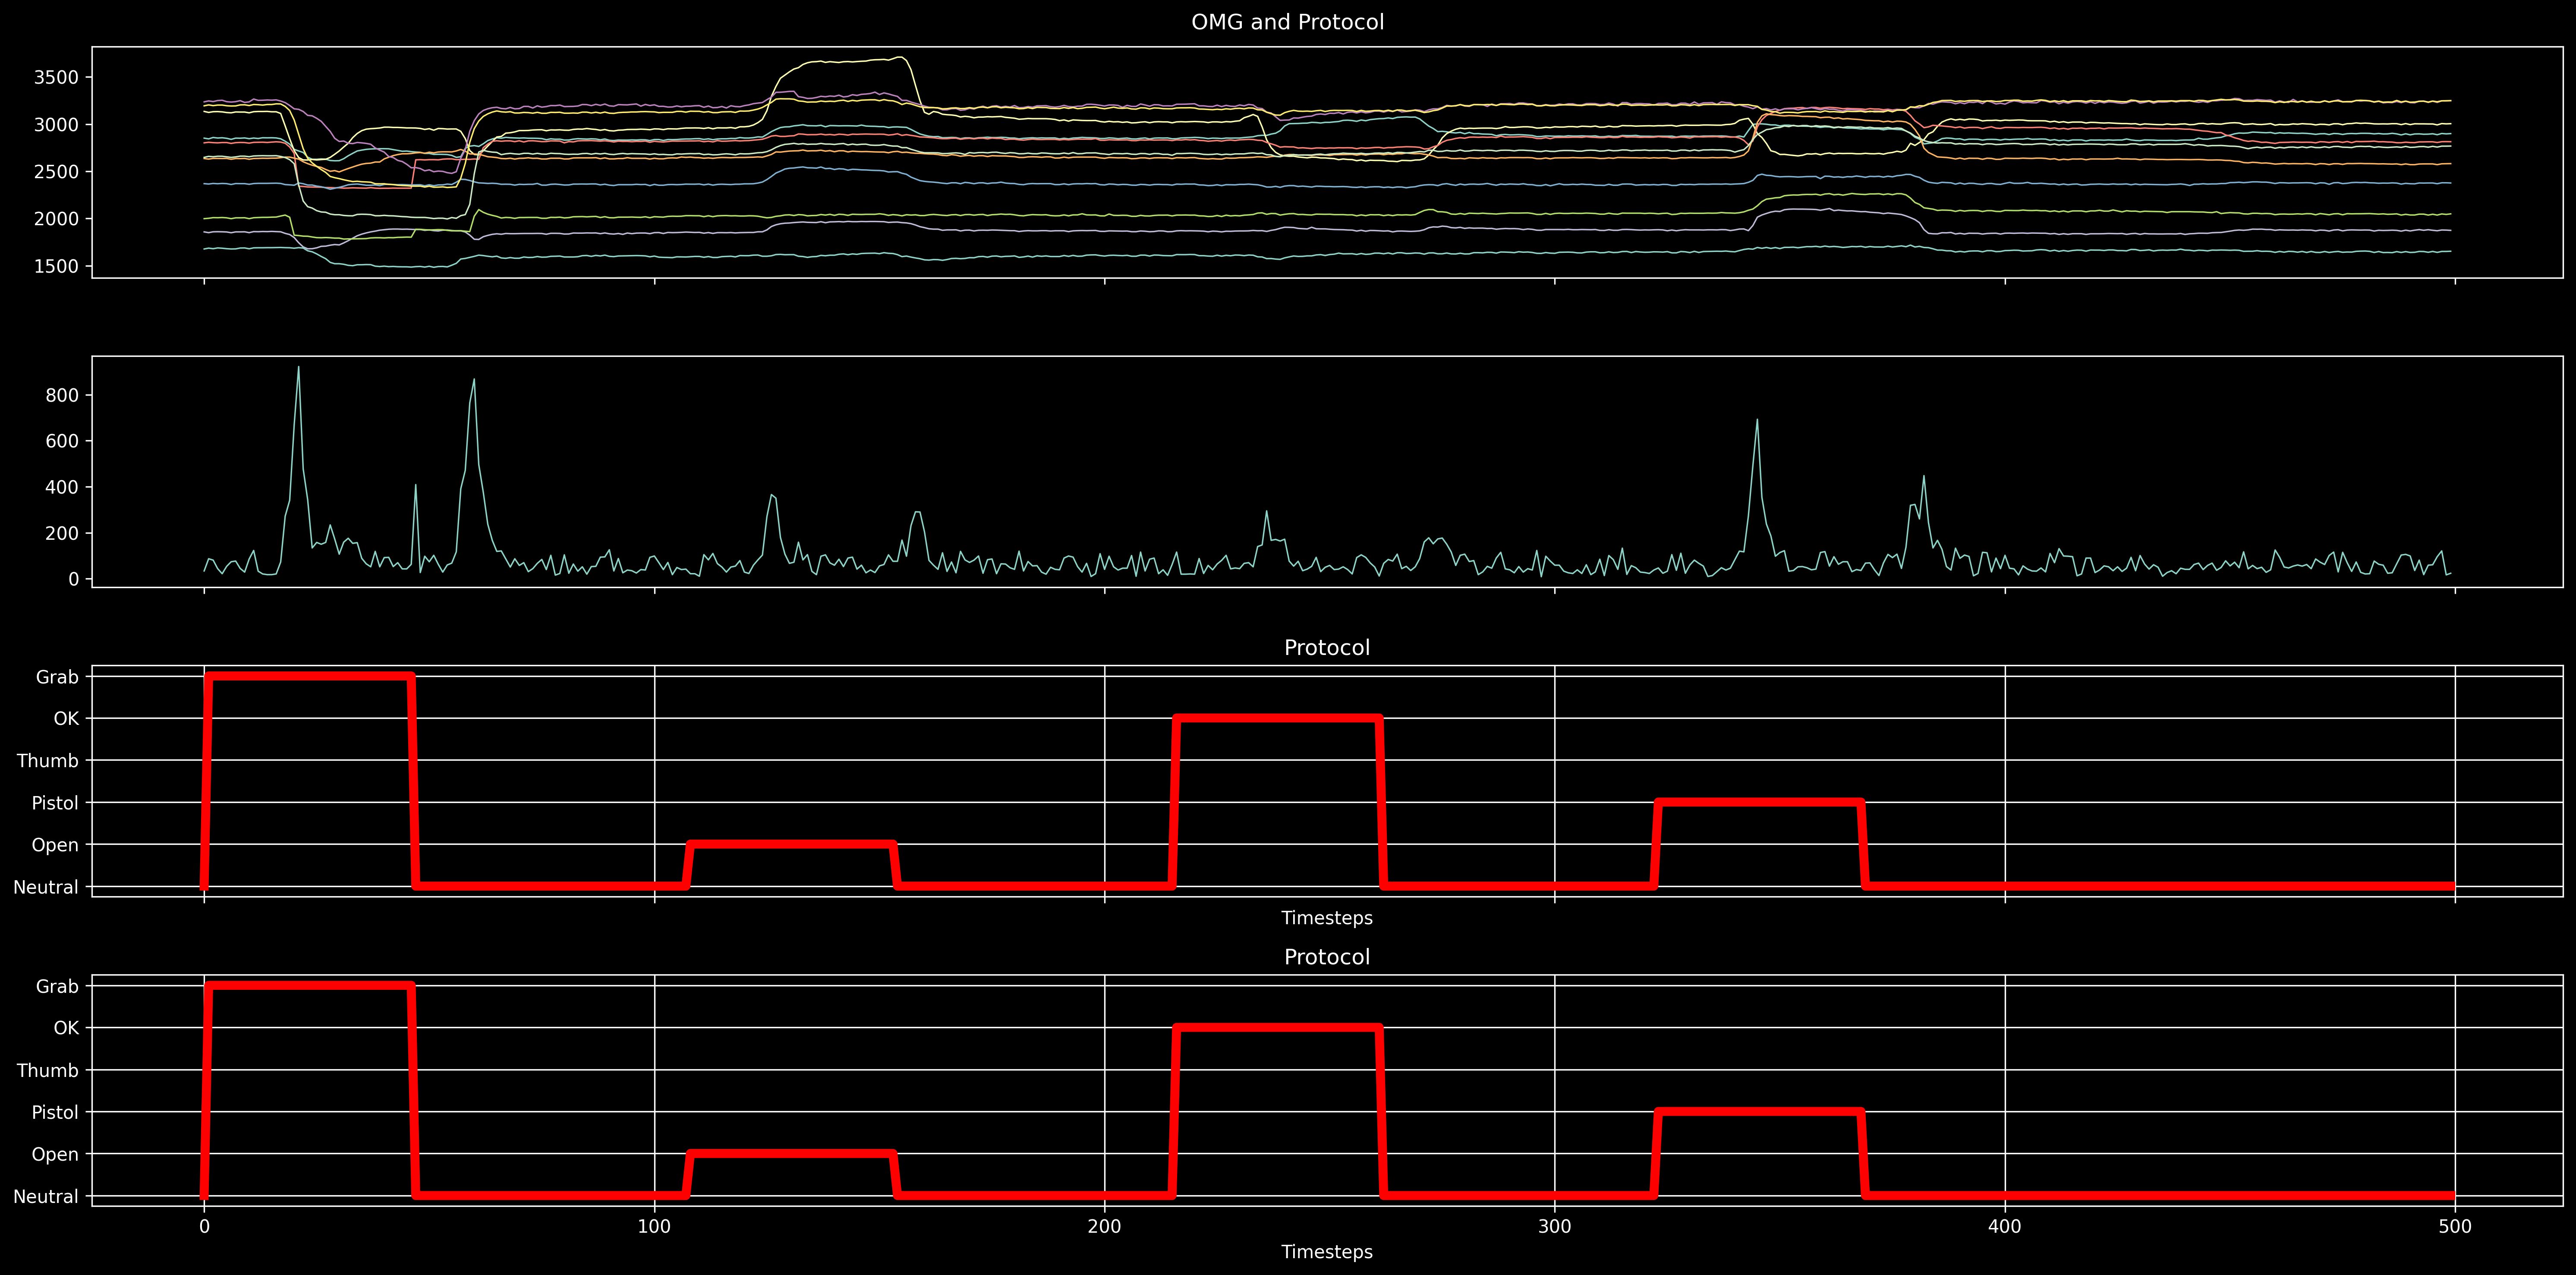

In [60]:


range_ = range(500, 1000)
# range_ = range(7400,8200)
# range_ = range(0,500)

data = df_clean[CLEAN_SENSORS_FINAL].values[range_]
# data = gestures['dif'].values[range_]

fig, axx = plt.subplots(4, 1, sharex=True, figsize=(20, 10), dpi=300)
plt.sca(axx[0])
plt.plot(data, linewidth=.8)

plt.sca(axx[1])
plt.plot(df_clean['diff'].values[range_], linewidth=.8)

plt.sca(axx[2])
plt.plot(y_cmd[range_], color='red', linewidth=5)
plt.grid()

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.sca(axx[3])
plt.plot(df_clean['gesture'].values[range_], color='red', linewidth=5)
plt.grid()

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')


plt.suptitle('OMG and Protocol')
plt.tight_layout()

In [61]:
# Находим изменения в столбце 'step'
step_changes = df_clean[df_clean['step'].diff() != 0]

changes_df_info = step_changes[['step', 'gesture']].copy()
changes_df_info['index'] = step_changes.index

# Переупорядочим колонки, если необходимо
changes_df_info = changes_df_info[['step', 'index', 'gesture']]

changes_df_info['diff'] = np.array(pd.concat([changes_df_info['index'].diff().iloc[1:],pd.Series([0])], axis=0).reset_index().drop(columns='index')[0])
changes_df_info = changes_df_info.reset_index().drop(columns='level_0').rename(columns={'index':'start_position'})
changes_df_info


step  start_position  gesture   diff
0       1               0        0  288.0
1       2             288        0   45.0
2       3             333        0   62.0
3       4             395        3   46.0
4       5             441        0   60.0
..    ...             ...      ...    ...
356   357           19327        0   62.0
357   358           19389        4   46.0
358   359           19435        0   60.0
359   360           19495        2   46.0
360   361           19541        0    0.0

[361 rows x 4 columns]

In [70]:
changes_df_info['fact_start'] = 0
changes_df_info['fact_finish'] = 0

In [71]:
changes_df_info

step  start_position  gesture   diff  fact_start  fact_finish
0       1               0        0  288.0           0            0
1       2             288        0   45.0           0            0
2       3             333        0   62.0           0            0
3       4             395        3   46.0           0            0
4       5             441        0   60.0           0            0
..    ...             ...      ...    ...         ...          ...
356   357           19327        0   62.0           0            0
357   358           19389        4   46.0           0            0
358   359           19435        0   60.0           0            0
359   360           19495        2   46.0           0            0
360   361           19541        0    0.0           0            0

[361 rows x 6 columns]

In [72]:
# Высчитаем смещение по каждым жестам
for row in changes_df_info.itertuples(index=True):
    if row.Index == 0:
        continue  
    if row.Index == len(changes_df_info) - 1:
        break
    changes_df_info.loc[int(row.Index),'fact_start'] =df_clean.loc[row.start_position:row.start_position + row.diff//2, 'diff'].idxmax()    
    changes_df_info.loc[int(row.Index),'fact_finish'] =df_clean.loc[(row.start_position + row.diff):((row.start_position + row.diff) + row.diff//2), 'diff'].idxmax()    
changes_df_info['fact_finish'] = changes_df_info['fact_finish'].astype(int)


In [73]:
changes_df_info.head(15)

step  start_position  gesture   diff  fact_start  fact_finish
0      1               0        0  288.0           0            0
1      2             288        0   45.0         302          342
2      3             333        0   62.0         342          414
3      4             395        3   46.0         414          459
4      5             441        0   60.0         469          521
5      6             501        5   46.0         521          560
6      7             547        0   61.0         560          626
7      8             608        1   46.0         626          658
8      9             654        0   62.0         658          736
9     10             716        4   46.0         736          772
10    11             762        0   61.0         772          845
11    12             823        2   46.0         845          882
12    13             869        0   61.0         882          960
13    14             930        0   46.0         953          997
14    15             976        0   62.0         997         1059

In [66]:
# Так как начало измерений часто бывает повторением нейтральной позиции и оно может быть достаточно долгим, определяем позицию, когда начался первый жест и потос вырежем данные с нчала до этой позиции
for row in changes_df_info.itertuples(index=True):
    if row.Index == 0:
        continue  
    if row.Index == len(changes_df_info) - 1:
        break
    if row.gesture != 0:
        start_slice = row.fact_start
        print(f'Передний срез: {start_slice}')
        break
print(f"Последний срез: {(last_slice:=changes_df_info[-2:-1]['fact_finish'].values[0])}")

Передний срез: 414
Последний срез: 19559.0


In [67]:
# Делаем смещение 
df_clean.loc[:,'gesture'] = 0
for row in changes_df_info.itertuples(index=True):
    df_clean.loc[row.fact_start:row.fact_finish,'gesture'] = row.gesture

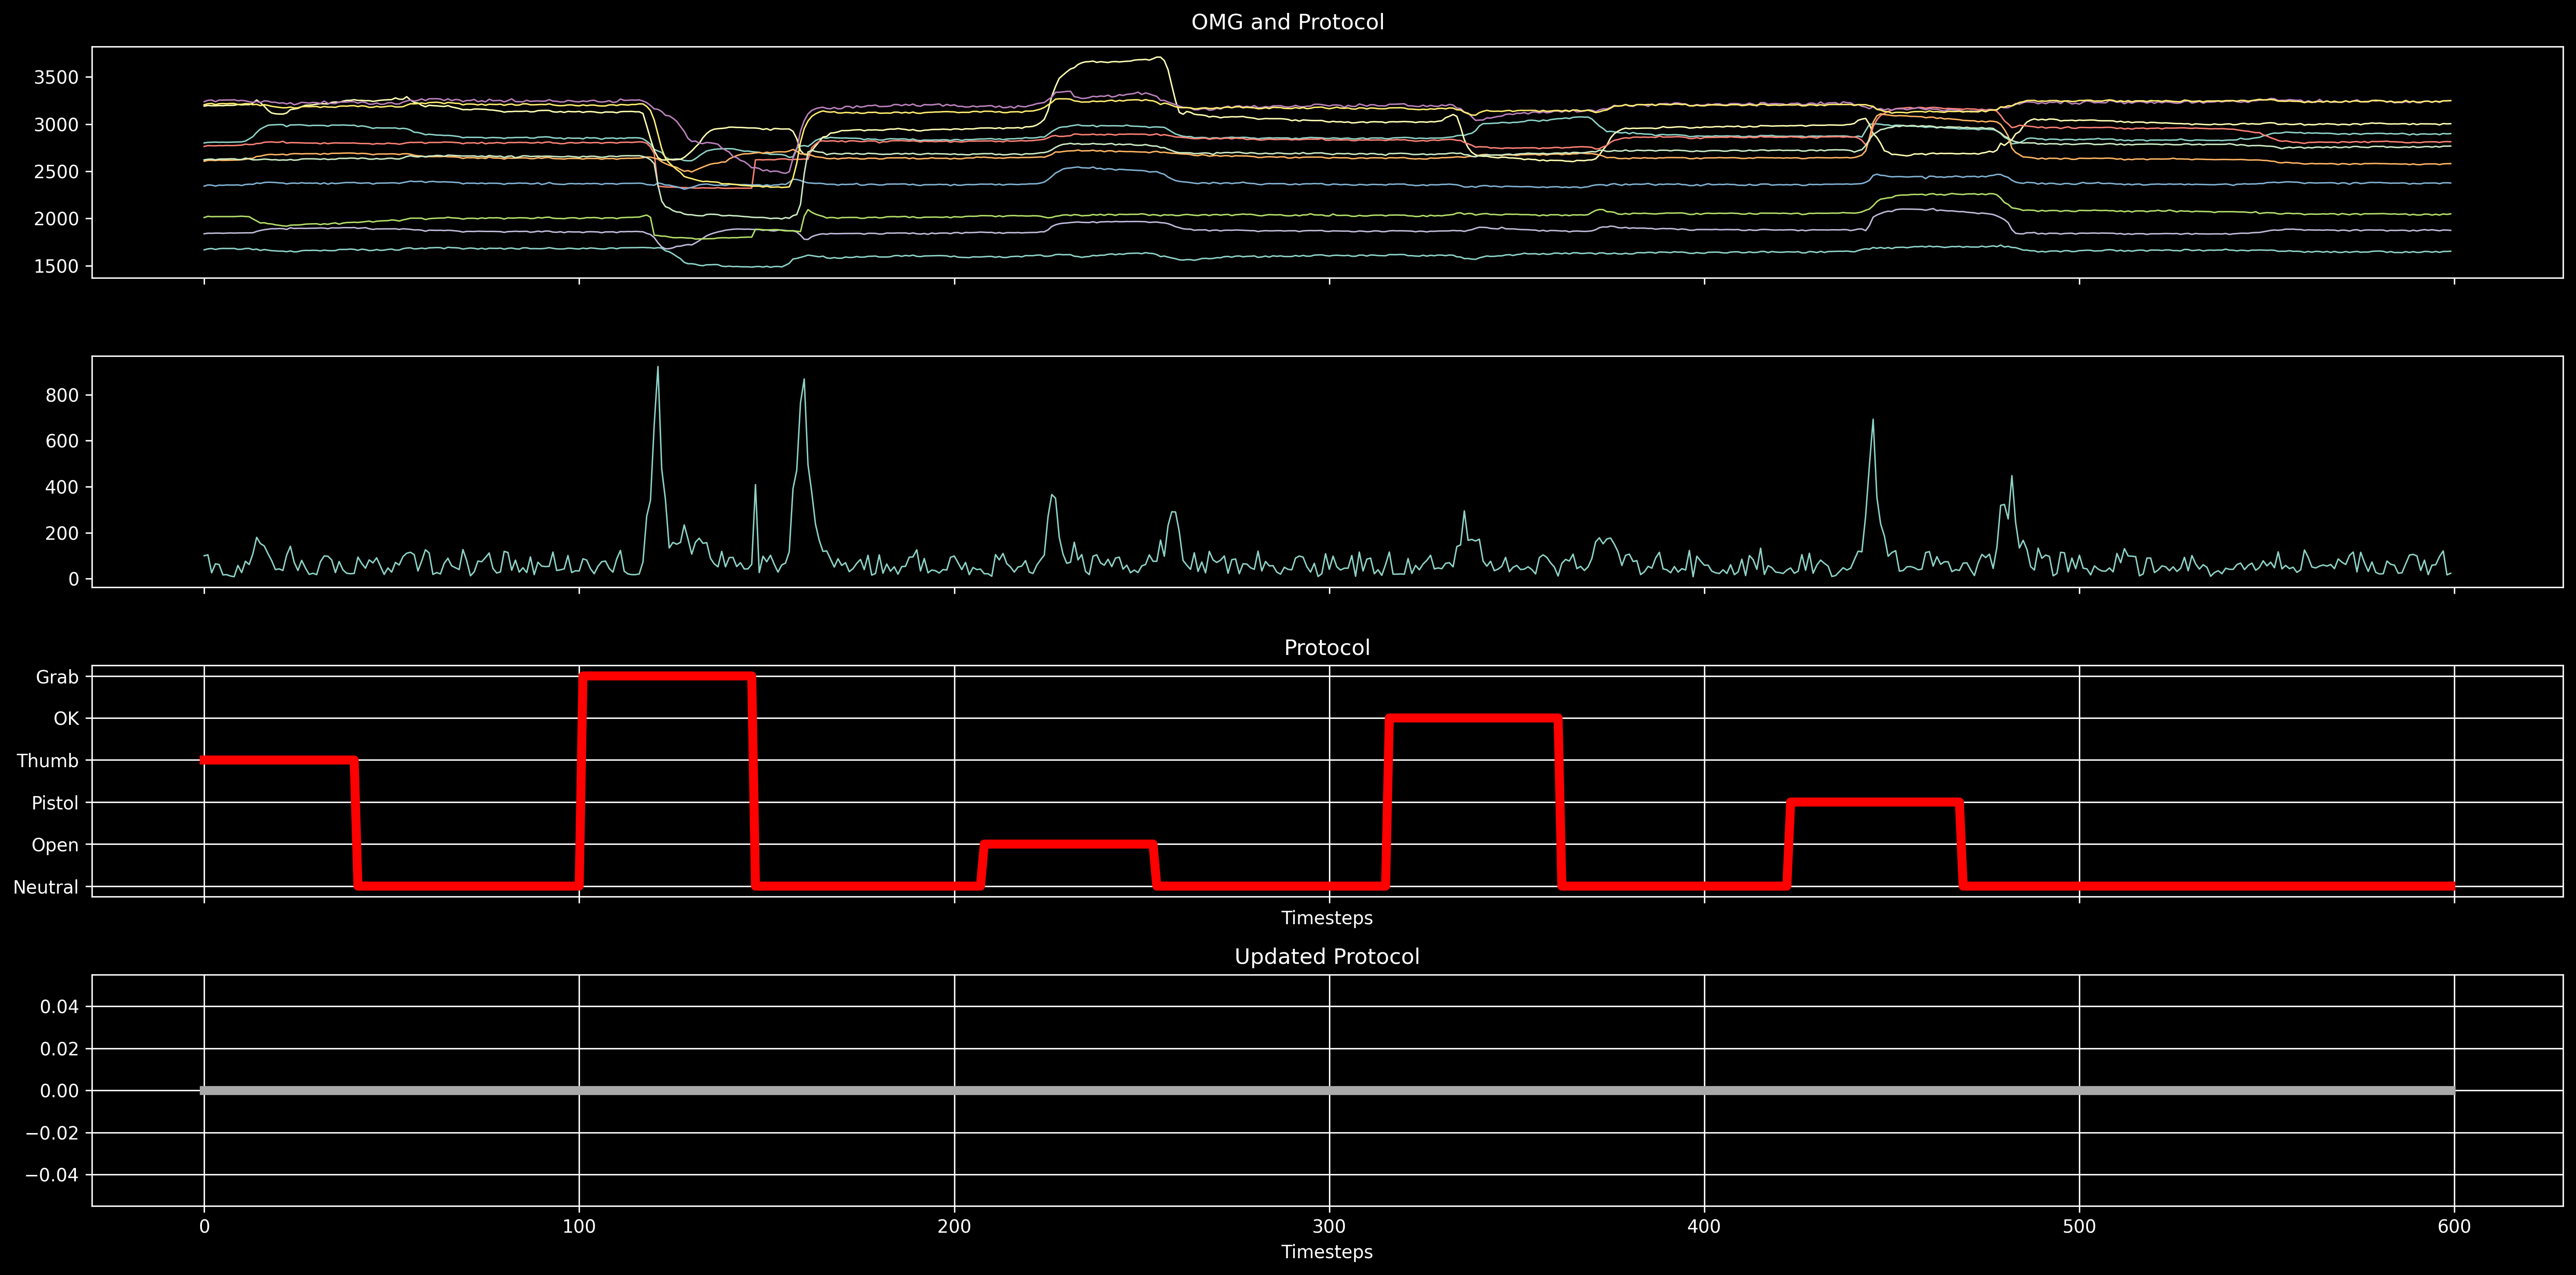

In [68]:


range_ = range(400, 1000)
# range_ = range(7400,8200)
# range_ = range(0,500)

data = df_clean[CLEAN_SENSORS_FINAL].values[range_]
# data = gestures['dif'].values[range_]

fig, axx = plt.subplots(4, 1, sharex=True, figsize=(20, 10), dpi=300)
plt.sca(axx[0])
plt.plot(data, linewidth=.8)

plt.sca(axx[1])
plt.plot(df_clean['diff'].values[range_], linewidth=.8)

plt.sca(axx[2])
plt.plot(y_cmd[range_], color='red', linewidth=5)
plt.grid()

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')

plt.sca(axx[3])
plt.plot(df_clean['gesture'].values[range_], color='darkgrey', linewidth=5)
plt.grid()

# plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Updated Protocol')


plt.suptitle('OMG and Protocol')
plt.tight_layout()

In [ ]:
# срежем датасет начало и конец по ранее полученным меткам
# df_clean = df_clean.iloc[start_slice:last_slice+1]

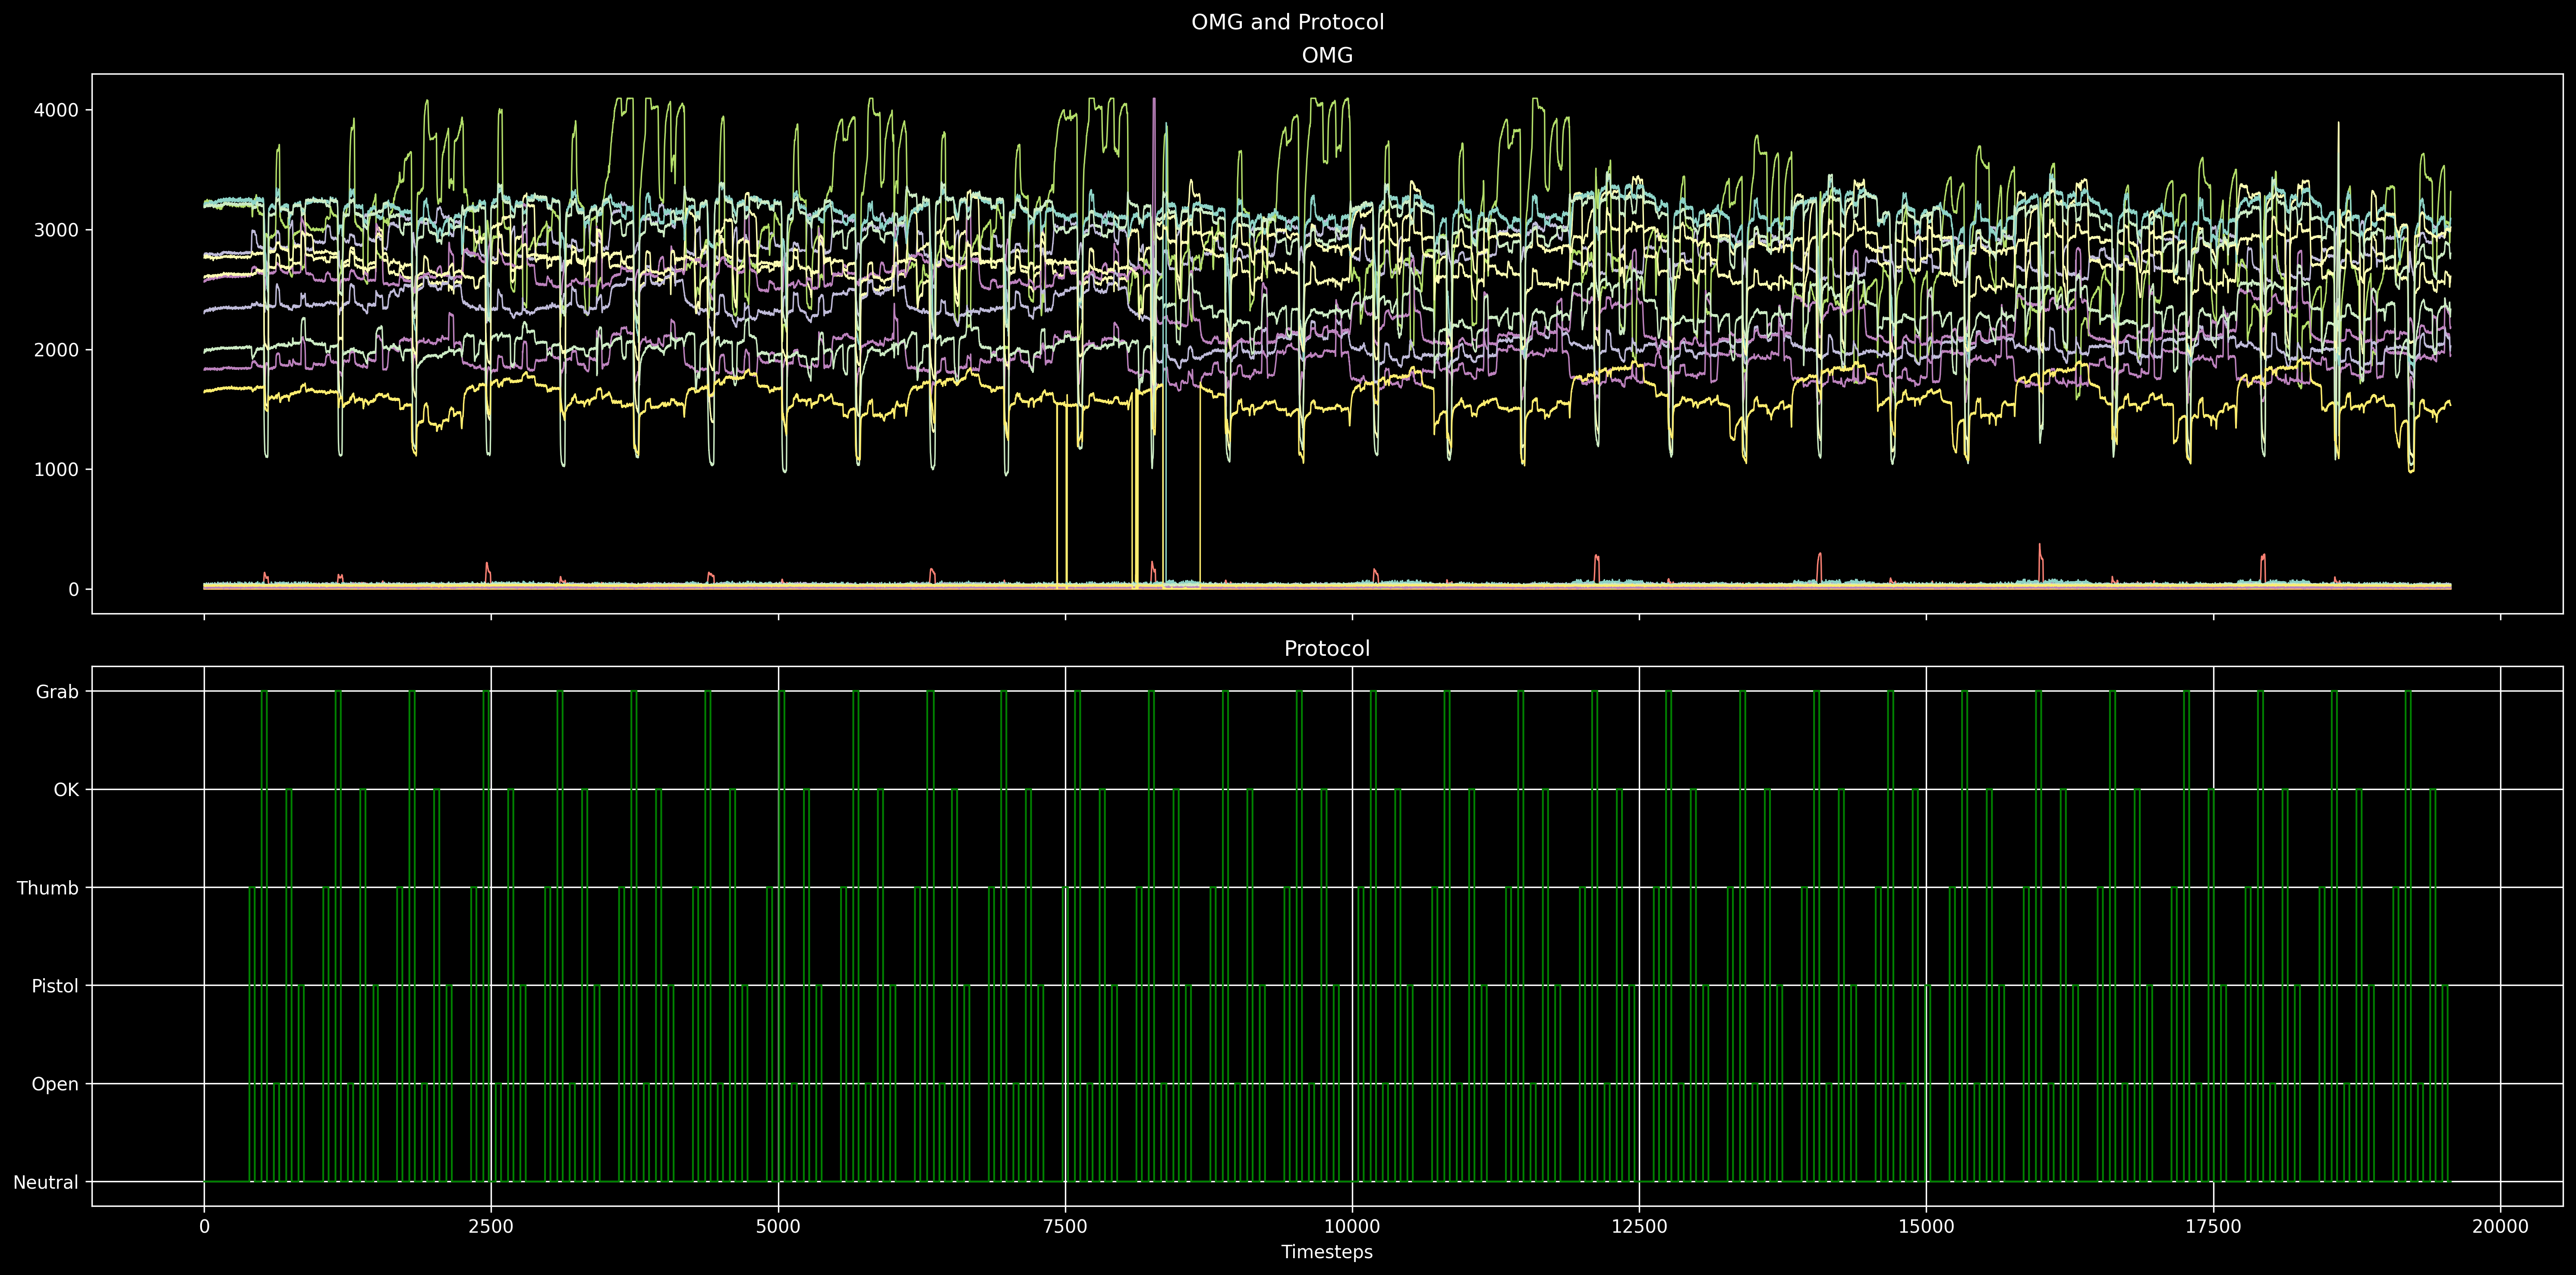

In [ ]:
fig, axx = plt.subplots(2, 1, sharex=True, figsize=(20, 10), dpi=300)
plt.sca(axx[0])
plt.plot(gestures[OMG_CH].values, linewidth=.8)
plt.title('OMG')


plt.sca(axx[1])
plt.plot(y_cmd, color='green', linewidth=1)
plt.grid()
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.xlabel('Timesteps')
plt.title('Protocol')


plt.suptitle('OMG and Protocol')
plt.tight_layout()

# Train-test split

In [ ]:
df_meta = pd.read_csv('./data/meta_information.csv', index_col=0)
df_meta.head()

montage  pilote_id  last_train_idx  len(train)  len(test)
0  2023-05-15_16-16-08.palm          1           23337       23337       5810
1  2023-05-15_17-12-24.palm          1           23336       23336       5803
2  2023-06-05_16-12-38.palm          1           17939       17939       4431
3  2023-06-05_17-53-01.palm          1           17771       17771       4435
4  2023-06-20_14-43-11.palm          1           17936       17936       4441

In [ ]:
last_train_idx = df_meta[df_meta['montage'] == palm_file.split('/')[-1]].to_dict(orient='records')[0]['last_train_idx']
last_train_idx

15679

In [ ]:
X_train = gestures[OMG_CH].values[:last_train_idx]
y_train = y_cmd[:last_train_idx]

X_test = gestures[OMG_CH].values[last_train_idx:]
y_test = y_cmd[last_train_idx:]

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(15679, 50) (15679,)
(3889, 50) (3889,)


# Modeling

In [ ]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(
    X=X_train,
    y=y_train
)

f:\Learnings\Motorika\Baseline\motorica-x-skillfactory-gestures\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

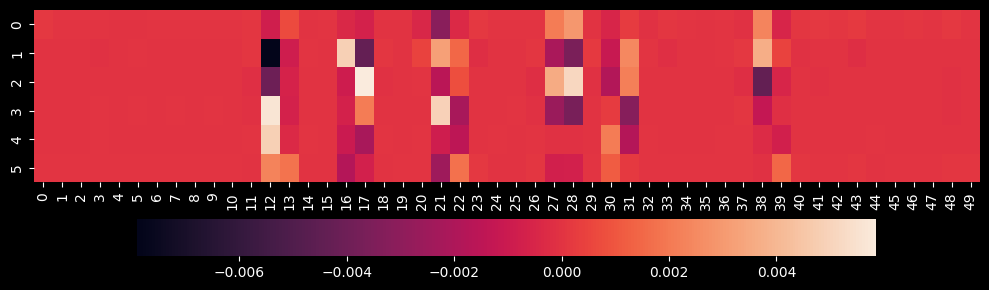

In [ ]:


plt.figure(figsize=(10, 3)) # 
sns.heatmap(model.coef_, cbar_kws={"orientation": "horizontal"})
plt.tight_layout()

## Prediction

In [ ]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

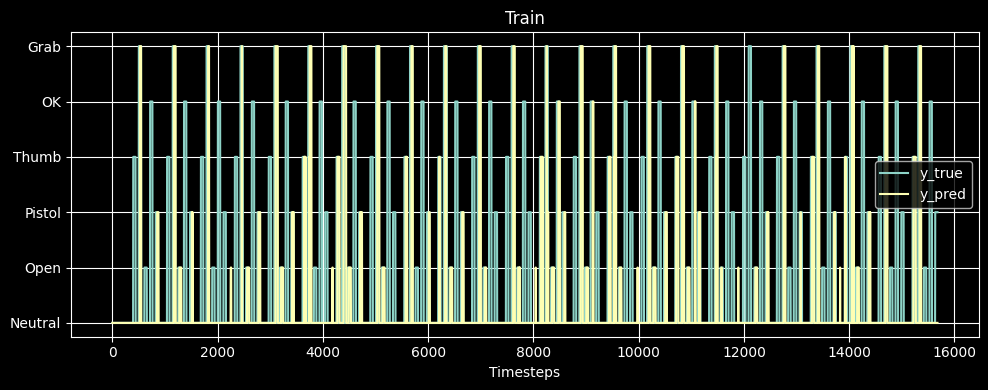

In [ ]:
fig = plt.figure(figsize=(10, 4))
plt.plot(y_train,  c='C0', label='y_true')
plt.plot(y_pred_train, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Train')
plt.tight_layout()

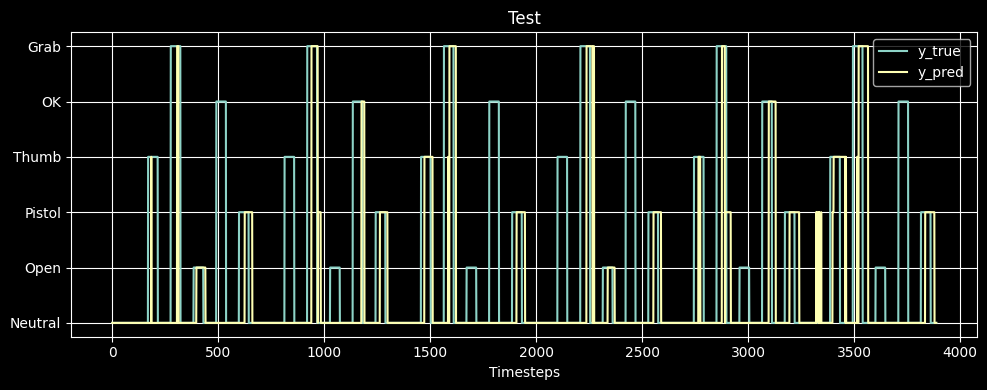

In [ ]:
fig = plt.figure(figsize=(10, 4))
plt.plot(y_test,  c='C0', label='y_true')
plt.plot(y_pred_test, c='C1', label='y_pred')

plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.grid()
plt.xlabel('Timesteps')
plt.legend()
plt.title('Test')
plt.tight_layout()

## Metrics

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_train, y_pred_train, target_names=GESTURES))
print(classification_report(y_test, y_pred_test, target_names=GESTURES))

              precision    recall  f1-score   support

     Neutral       0.69      0.94      0.80     10151
        Open       0.69      0.36      0.47      1104
      Pistol       0.69      0.20      0.31      1098
       Thumb       0.64      0.17      0.26      1104
          OK       0.42      0.02      0.04      1104
        Grab       0.64      0.41      0.50      1118

    accuracy                           0.69     15679
   macro avg       0.63      0.35      0.40     15679
weighted avg       0.67      0.69      0.63     15679

              precision    recall  f1-score   support

     Neutral       0.70      0.89      0.78      2508
        Open       0.74      0.20      0.32       276
      Pistol       0.48      0.51      0.50       276
       Thumb       0.63      0.25      0.36       276
          OK       0.43      0.07      0.12       276
        Grab       0.66      0.38      0.48       277

    accuracy                           0.67      3889
   macro avg       0.60

# Real-time inference

In [ ]:
crc_table = [
    54, 181, 83, 241, 89, 16, 164, 217, 34, 169, 220, 160, 11, 252,
    111, 241, 33, 70, 99, 240, 234, 215, 60, 206, 68, 126, 152, 81,
    113, 187, 14, 21, 164, 172, 251, 16, 248, 215, 236, 90, 49, 53,
    179, 156, 101, 55, 65, 130, 161, 22, 218, 79, 24, 168, 152, 205,
    115, 141, 23, 86, 141, 58, 122, 215, 252, 48, 69, 115, 138, 66,
    88, 37, 63, 104, 176, 46, 139, 246, 222, 184, 103, 92, 154, 174,
    97, 141, 195, 166, 227, 150, 140, 48, 121, 243, 13, 131, 210, 199,
    45, 75, 180, 104, 97, 82, 251, 90, 132, 111, 229, 175, 146, 216,
    153, 86, 166, 33, 184, 100, 225, 248, 186, 54, 89, 39, 2, 214, 2,
    114, 197, 6, 35, 188, 245, 64, 220, 37, 123, 132, 190, 60, 189, 53,
    215, 185, 238, 145, 99, 226, 79, 54, 102, 118, 210, 116, 51, 247,
    0, 191, 42, 45, 2, 132, 106, 52, 63, 159, 229, 157, 78, 165, 50,
    18, 108, 193, 166, 253, 3, 243, 126, 111, 199, 152, 36, 114, 147,
    57, 87, 14, 16, 160, 128, 97, 189, 51, 115, 142, 8, 70, 71, 55, 42,
    193, 65, 207, 122, 158, 26, 21, 72, 139, 33, 230, 230, 116, 134, 5,
    213, 165, 107, 41, 134, 219, 190, 26, 29, 136, 174, 190, 108, 185, 172,
    137, 239, 164, 208, 207, 206, 98, 207, 12, 0, 174, 64, 20, 90, 49, 12,
    67, 112, 109, 78, 114, 165, 244, 183, 121
];
    
def get_crc(data, count):
    result = 0x00
    l = count
    while (count>0):   
        result = crc_table[result ^ data[l-count]]
        count -= 1;
    return result;

def drv_abs_one(ser, control):
    if ser is None:
        return
    pack = (np.array([80, 0x01, 0xBB, 6] + [c for c in control] + [0], dtype='uint8'))
    pack[-1] = get_crc(pack[1:], 9)
    return (pack, ser.write(bytearray(pack)))

## Inference Utils: Put your code here

In [ ]:
def preprocessing(x):
    # x - sample vector
    y = x
    return y

def inference(x):
    y = model.predict([x])
    return y

def postprocessing(x, prev):
    if prev is None:
        y = x
    else:
        y = x*0.1 + prev*0.9 # Holt-Winters filter
    return y

def commands(x):
    y = np.round(np.clip(x / 100, 0, 1)*100).astype(int)
    return y

## Inference

### Offline (dataset)

In [ ]:
df_sim = gestures.iloc[last_train_idx:]
print(df_sim.shape)

(3889, 65)


In [ ]:
TIMEOUT = 0.033
DEBUG = False
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
y_dct = {
    'omg_sample':[],
    'enc_sample':[],
    'sample_preprocessed':[],
    
    'y_predicted':[],
    'y_postprocessed':[],
    'y_commands':[],
}
while True:    
    
    # [Data reading]
    ts_start = time.time()
    
    try:
        # [Sim data]
        if i < len(df_sim):
            sample = df_sim.values[i]
        else:
            break
        # [/Sim data]
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    # NO COMMANDS SENDING IN SIMULATION
    # [/Commands sending]
    
    # [Data logging]
    y_dct['omg_sample'].append(omg_sample)
    y_dct['enc_sample'].append(enc_sample)
    y_dct['sample_preprocessed'].append(sample_preprocessed)
    y_dct['y_predicted'].append(y_predicted)
    y_dct['y_postprocessed'].append(y_postprocessed)
    y_dct['y_commands'].append(y_commands)
    # [/Data logging]

    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

In [ ]:
for key, val in y_dct.items():
    # print(f"len({key}) = {len(y_dct[key])}")
    y_dct[key] = np.stack(val)
    print(f"{key}.shape = {y_dct[key].shape}")

omg_sample.shape = (3889, 50)
enc_sample.shape = (3889, 6)
sample_preprocessed.shape = (3889, 50)
y_predicted.shape = (3889, 1)
y_postprocessed.shape = (3889, 1)
y_commands.shape = (3889, 1)


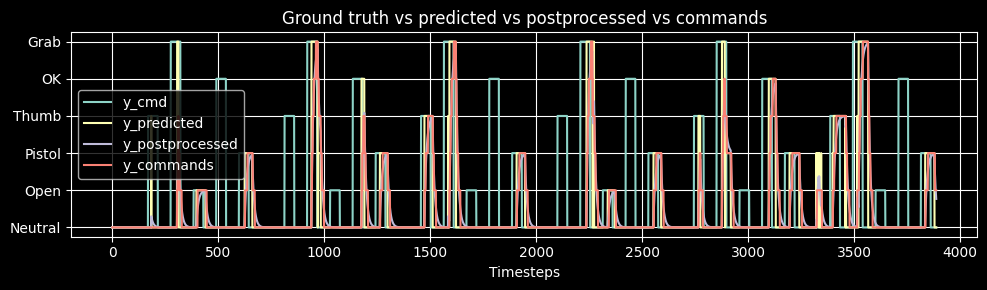

In [ ]:
fig = plt.figure(figsize=(10, 3))

plt.plot(y_test, c='C0', label='y_cmd')
plt.plot(y_dct['y_predicted'], c='C1', label='y_predicted')
plt.plot(y_dct['y_postprocessed'], c='C2', label='y_postprocessed')
plt.plot(y_dct['y_commands'], c='C3', label='y_commands')

plt.title('Ground truth vs predicted vs postprocessed vs commands')
plt.yticks(np.arange(len(GESTURES)), GESTURES)
plt.legend()
plt.grid()
plt.xlabel('Timesteps')

plt.tight_layout()

In [ ]:
print(classification_report(y_test, y_dct['y_commands'], target_names=GESTURES))

              precision    recall  f1-score   support

     Neutral       0.67      0.78      0.72      2508
        Open       0.11      0.16      0.13       276
      Pistol       0.22      0.23      0.23       276
       Thumb       0.20      0.11      0.14       276
          OK       0.00      0.00      0.00       276
        Grab       0.12      0.02      0.04       277

    accuracy                           0.54      3889
   macro avg       0.22      0.22      0.21      3889
weighted avg       0.48      0.54      0.50      3889



### Online (prosthesis or virtual hand)

In [ ]:
TIMEOUT = 0.033
DEBUG = True

ser = None
# ser_port = None
# ser_port = '/dev/ttyACM0'
ser_port = '/dev/cu.usbmodem3498365F31351'

if ser_port is not None:
    ser = serial.Serial(port=ser_port, timeout=2*TIMEOUT)
    ser.write('T1#\r\n'.encode('utf-8')) # T1 for Timestamp activate
    ser.write('M2#\r\n'.encode('utf-8')) # M2 for Mode == 2 = send samples
    ser.write('S2#\r\n'.encode('utf-8')) # SYNC to 2 for sanity check

    # flush buffers
    ser.reset_input_buffer()
    ser.read()
    
    i = 0;
    while(ser.in_waiting):
        print(f'Flushing buffers {i}: {ser.in_waiting}', end='    \r')
        ser.read_all()
        time.sleep(0.005)
        i+=1;
    ser.readline()
    ser.readline()
    
i = 0
ts_old = time.time()
ts_diff = 0;

y_previous = None
while True:    
    
    # [Data reading]
    s = ser.readline()
    ts_start = time.time()
    
    try:
        sample = np.array(s.decode('UTF-8')\
                           .replace('\r\n', "")\
                           .split(' ')
                         ).astype(int)
        [omg_sample, acc_sample, enc_sample, [button, sync, ts]] = np.array_split(sample, [50, 56, 62])
        
    except Exception as e:
        print(e)
        
    # [/Data Reading]
        
    # [Data preprocessing]
    sample_preprocessed = preprocessing(omg_sample)
    # [/Data preprocessing]
    
    # [Inference]
    y_predicted         = inference(sample_preprocessed)
    # [/Inference]
    
    # [Inference Postprocessing]
    y_postprocessed     = postprocessing(y_predicted, y_previous)
    # [/Inference Postprocessing]
    
    # [Commands composition]
    y_commands          = commands(y_postprocessed)
    # [/Commands composition]
    
    # [Commands sending]
    pack, _ = drv_abs_one(ser, list(y_commands)); # + [0]
    # [/Commands sending]
    
    y_previous = y_postprocessed
    
    if DEBUG:
        clear_output(wait=True)

        # sanity check: iteration should increase monotonically, TIMEDIFF approximately 32-34 ms, CYCLETIME < TIMEOUT, WAITING should be == 0
        print(f'ITERATION:\t{i}\tTIMEDIFF:\t{(ts_start - ts_old)*1000: .0f}\tCYCLETIME:\t{ts_diff*1000:.0f}\tWAITING:\t{ser.in_waiting}')
        print('INPUT:\n', s)

        # sanity check: Sizes of SAMPLE=65, OMG=50, ACC=6, ENCODERS=6
        print(f'SAMPLE SIZE: {len(sample)}, OMG: {len(omg_sample)}, ACC: {len(acc_sample)}, ENCODERS: {len(enc_sample)}')
        print(f'BUTTON: {button}, SYNC: {sync}, TS: {ts}')
        print(y_commands)
        print(pack)
    
    ts_diff = time.time() - ts_start
    assert(ts_diff<TIMEOUT), 'Calculation cycle takes more than TIMEOUT, halting...'
    ts_old = ts_start
    i += 1 

SerialException: could not open port '/dev/cu.usbmodem3498365F31351': FileNotFoundError(2, 'The system cannot find the path specified.', None, 3)

In [ ]:
feature_range = [str(i) for i in range(0, 50)]

def create_difference_features(df):
    features_to_diff = [col for col in df.columns if col in feature_range]
    
    # Вычисление разности только для выбранных признаков
    diff_df = df[features_to_diff].diff().fillna(0)  # Вычисляем разницу и заполняем NaN нулями
    diff_df.columns = [f'{col}_diff' for col in features_to_diff]  # Переименовываем столбцы
    
    # Объединяем исходный DataFrame с новыми признаками
    return pd.concat([df, diff_df], axis=1)

# Применение функции
df_with_diff = create_difference_features(gestures)



df_with_diff_and_gesture = pd.merge(df_with_diff, gestures_protocol['gesture'], how = 'inner', left_on='SYNC', right_index=True)

In [ ]:
df_with_diff_and_gesture.step.max()

np.int64(361)

12,16,17,21,22,27,28,30,31,38,39


In [ ]:
plotly_sensor(df_with_diff_and_gesture, 3, '39')

In [ ]:
np.median(v_cos_sum)

np.float64(0.9998129999771526)

In [ ]:
df_with_diff_and_gesture[['30','30_diff','SYNC','gesture']]

30  30_diff  SYNC  gesture
0      3199      0.0     0        0
1      3216     17.0     0        0
2      3199    -17.0     0        0
3      3216     17.0     0        0
4      3207     -9.0     0        0
...     ...      ...   ...      ...
19563  3045    -17.0     0        0
19564  3069     24.0     0        0
19565  3082     13.0     0        0
19566  3082      0.0     0        0
19567  3093     11.0     0        0

[19568 rows x 4 columns]

In [ ]:
grouped_stats = df_with_diff_and_gesture.groupby(['SYNC', 'step', 'gesture'])['39'].agg(['min', 'max', 'mean', 'std']).reset_index()
grouped_stats['min_max_diff'] = grouped_stats['max'] - grouped_stats['min']
grouped_stats[grouped_stats.gesture == 0].sort_values(by='std',ascending=False)

SYNC  step  gesture   min   max         mean         std  min_max_diff
259    79   158        0     0  1726  1029.152174  833.389704          1726
73      0   147        0     0  1668   780.467742  811.144945          1668
67      0   135        0     0  1555  1484.040816  309.246663          1555
177     0   355        0   972  1446  1203.114754  214.739928           474
247    67   134        0     2  1638  1563.586207  211.464155          1636
..    ...   ...      ...   ...   ...          ...         ...           ...
181     1     2        0  1661  1682  1674.088889    5.177847            21
43      0    87        0  1683  1700  1692.213115    5.148187            17
76      0   153        0     0     8     1.704918    1.054265             8
77      0   155        0     0     4     1.508197    0.766441             4
78      0   157        0     0     3     1.467742    0.717869             3

[211 rows x 8 columns]

In [ ]:
grouped_stats[grouped_stats.gesture == 0].sort_values(by=['mean','min_max_diff'],ascending=[False, True])[26:31]

SYNC  step  gesture   min   max         mean        std  min_max_diff
147     0   295        0  1629  1827  1769.661290  70.314969           198
94      0   189        0  1697  1787  1763.129032  24.338113            90
129     0   259        0  1585  1829  1761.885246  84.791528           244
41      0    83        0  1746  1775  1759.360656   5.811003            29
109     0   219        0  1709  1782  1758.885246  16.928377            73

In [ ]:
[df[df.SYNC == value][f'{attr}'].to_numpy() for value in columns]

In [ ]:
def vectors_for_average_calc(df, df_stats, count = 5):
    vs = {}
    
    for attr in range(0,50):  
        vector_mean = {}  
        for idx in range(0,6):
            
            start = df_stats[df_stats.gesture == idx].shape[0]//4
            columns = df_stats[df_stats.gesture == idx].sort_values(by=['mean','min_max_diff'],ascending=[False, True]).iloc[start:start + count].step.values

            vectors = [df[df.step == value][f'{attr}'].to_numpy() for value in columns]
            max_len = max(len(arr) for arr in vectors)

            for i, vector in enumerate(vectors):
                if len(vector) != max_len:
                    vectors[i] = interpolate_vector(vector, max_len)
            vector_mean[idx] = np.mean(vectors, axis=0)
            
        vs[attr] = vector_mean    
            
        
    return vs        
    
def interpolate_vector(vector, new_length):
    x = np.linspace(0, 1, len(vector))
    f = interp1d(x, vector, kind='linear')
    new_x = np.linspace(0, 1, new_length)
    return f(new_x)


    

In [ ]:
grouped_stats[grouped_stats.gesture == 0].sort_values(by='std', ascending=True)

SYNC  step  gesture   min   max         mean         std  min_max_diff
78      0   157        0     0     3     1.467742    0.717869             3
77      0   155        0     0     4     1.508197    0.766441             4
76      0   153        0     0     8     1.704918    1.054265             8
43      0    87        0  1683  1700  1692.213115    5.148187            17
181     1     2        0  1661  1682  1674.088889    5.177847            21
..    ...   ...      ...   ...   ...          ...         ...           ...
247    67   134        0     2  1638  1563.586207  211.464155          1636
177     0   355        0   972  1446  1203.114754  214.739928           474
67      0   135        0     0  1555  1484.040816  309.246663          1555
73      0   147        0     0  1668   780.467742  811.144945          1668
259    79   158        0     0  1726  1029.152174  833.389704          1726

[211 rows x 8 columns]

In [ ]:
v = vectors_for_average_calc(df_with_diff_and_gesture, grouped_stats)



In [ ]:
v[39][3].min()

np.float64(1645.2)

In [ ]:
def cosine_similarity(a,b):
    print(np.dot(a, b) / (norm(a) * norm(b)))



def cosine_similarity_calculation(row, initial_vector, df, column):
    # if row.SYNC == 0 or row.gesture == 0: return 0
    
    mean_vector = np.array(initial_vector[int(row.gesture)])
    data_vector = df[df['step'] == row.step][column].to_numpy()
    
    if data_vector.shape != mean_vector.shape:
        data_vector = interpolate_vector(data_vector, (mean_vector.shape[0]))
        
    # print('mean_vector')    
    # print(mean_vector)
    # print('data_vector')    
    # print(data_vector)    
    return np.dot(mean_vector,data_vector)/ (norm(mean_vector)*norm(data_vector))
    

In [ ]:
df_with_diff_and_gesture.step

0          1
1          1
2          1
3          1
4          1
        ... 
19563    361
19564    361
19565    361
19566    361
19567    361
Name: step, Length: 19568, dtype: int64

In [ ]:
for idx in range(0,50):
    grouped_stats[f'{idx}_cs'] = grouped_stats.apply(lambda x: cosine_similarity_calculation(x,v, df_with_diff_and_gesture,f'{idx}'), axis = 1)


In [ ]:
grouped_stats[grouped_stats.gesture == 0]

SYNC  step  gesture   min   max         mean        std  min_max_diff
0       0     1        0  1639  1693  1668.562500  11.454329            54
1       0     3        0  1664  1687  1675.870968   5.713039            23
2       0     5        0  1660  1695  1680.216667   8.346504            35
3       0     7        0  1483  1612  1578.786885  38.990219           129
4       0     9        0  1557  1617  1595.903226  15.272079            60
..    ...   ...      ...   ...   ...          ...        ...           ...
331   151   302        0  1710  1880  1813.630435  65.441529           170
337   157   314        0  1530  1624  1578.434783  33.265700            94
343   163   326        0  1343  1701  1530.239130  94.761029           358
349   169   338        0  1730  1894  1829.130435  65.158476           164
355   175   350        0  1527  1612  1576.608696  26.288551            85

[211 rows x 8 columns]

In [ ]:
mean_stats = grouped_stats[(f'{idx}_cs' for idx in range(0,50))].mean()


12,16,17,21,22,27,28,30,31,38,39

In [ ]:
# Проверяем где мы имеем повторение паттерна, т.е. устойчивую тенденцию повторяемости сигнала
# где меньше 0.8 - это уже говорит о больше предоставлении шума с сенсора, чем реальных данных
mean_stats

0_cs     0.916634
1_cs     0.956254
2_cs     0.939581
3_cs     0.931545
4_cs     0.868555
5_cs     0.708681
6_cs     0.944349
7_cs     0.934573
8_cs     0.977233
9_cs     0.971279
10_cs    0.736168
11_cs    0.952640
12_cs    0.994554
13_cs    0.897367
14_cs    0.945519
15_cs    0.743021
16_cs    0.990008
17_cs    0.994469
18_cs    0.941217
19_cs    0.813247
20_cs    0.959888
21_cs    0.988909
22_cs    0.994571
23_cs    0.938455
24_cs    0.890179
25_cs    0.764028
26_cs    0.990377
27_cs    0.994107
28_cs    0.989938
29_cs    0.968741
30_cs    0.992635
31_cs    0.993256
32_cs    0.992347
33_cs    0.931621
34_cs    0.894048
35_cs    0.772920
36_cs    0.979107
37_cs    0.992496
38_cs    0.993754
39_cs    0.989875
40_cs    0.986652
41_cs    0.986672
42_cs    0.982231
43_cs    0.975782
44_cs    0.887783
45_cs    0.734636
46_cs    0.983675
47_cs    0.984997
48_cs    0.992675
49_cs    0.986141
dtype: float64

In [ ]:
# выберем то сенсоры, где паттерн стабильный
GSS = mean_stats[mean_stats>0.98]
GSS

12_cs    0.994554
16_cs    0.990008
17_cs    0.994469
21_cs    0.988909
22_cs    0.994571
26_cs    0.990377
27_cs    0.994107
28_cs    0.989938
30_cs    0.992635
31_cs    0.993256
32_cs    0.992347
37_cs    0.992496
38_cs    0.993754
39_cs    0.989875
40_cs    0.986652
41_cs    0.986672
42_cs    0.982231
46_cs    0.983675
47_cs    0.984997
48_cs    0.992675
49_cs    0.986141
dtype: float64

In [ ]:
grouped_stats[(grouped_stats.gesture == 1)][['step','39_cs','SYNC']]
# теперь проверим показатели по шагам, если паттерн "кривой", заменим его на среднее згначение для данного паттерна для данного шага
# grouped_stats[(grouped_stats.gesture == 0) & (grouped_stats['39_cs']<.980)][['step','39_cs']]

step     39_cs  SYNC
184     8  0.999925     4
190    20  0.999983    10
196    32  0.999648    16
202    44  0.999624    22
208    56  0.999990    28
214    68  0.999933    34
220    80  0.999703    40
226    92  0.999970    46
232   104  0.999913    52
238   116  0.999760    58
244   128  0.999975    64
250   140  0.999897    70
256   152  0.559822    76
262   164  0.999896    82
268   176  0.999904    88
274   188  0.999689    94
280   200  0.999960   100
286   212  0.999924   106
292   224  0.999691   112
298   236  0.999981   118
304   248  0.999917   124
310   260  0.999768   130
316   272  0.999980   136
322   284  0.999859   142
328   296  0.999727   148
334   308  0.999954   154
340   320  0.999651   160
346   332  0.999672   166
352   344  0.999929   172
358   356  0.999771   178

In [ ]:
v[0]

array([1671. , 1671.4, 1667.4, 1670.8, 1669.4, 1674. , 1673.2, 1673.6,
       1672.2, 1673. , 1674.8, 1673.4, 1670.2, 1675.2, 1672. , 1675.4,
       1672.6, 1670.4, 1674. , 1666.6, 1668.2, 1667.4, 1663.8, 1660.4,
       1653. , 1641.8, 1634.6, 1625.8, 1620.4, 1613. , 1608.6, 1603.6,
       1604. , 1606.2, 1605.2, 1609.2, 1610.6, 1612.8, 1611.2, 1615.2,
       1616.6, 1612. , 1616. , 1618.4, 1618.4, 1620.6])

In [ ]:
df_with_diff_and_gesture[df_with_diff_and_gesture.SYNC == 87]['39']

9516    1503.0
9517    1503.0
9518    1501.0
9519    1503.0
9520    1499.0
9521    1492.0
9522    1492.0
9523    1491.0
9524    1490.0
9525    1504.0
9526    1502.0
9527    1500.0
9528    1494.0
9529    1502.0
9530    1490.0
9531    1489.0
9532    1478.0
9533    1415.0
9534    1224.0
9535    1133.0
9536    1128.0
9537    1131.0
9538    1141.0
9539    1116.0
9540    1120.0
9541    1121.0
9542    1135.0
9543    1137.0
9544    1128.0
9545    1139.0
9546    1139.0
9547    1133.0
9548    1141.0
9549    1130.0
9550    1134.0
9551    1134.0
9552    1131.0
9553    1119.0
9554    1126.0
9555    1124.0
9556    1121.0
9557    1111.0
9558    1117.0
9559    1115.0
9560    1111.0
9561    1100.0
Name: 39, dtype: float64

In [ ]:
mask = df_with_diff_and_gesture.SYNC == 87
len(df_with_diff_and_gesture[mask]['39'])

46

In [ ]:
# Проверяем, что длины совпадают

sync_value = 163
guesture = 0

mask = df_with_diff_and_gesture.SYNC == sync_value

if (vl:=len(df_with_diff_and_gesture[mask]['39'])) == len(v[guesture]):
    # Заменяем значения в колонке '39'
    df_with_diff_and_gesture.loc[mask, '39'] = v[guesture]
else:
    # print("Ошибка: Длины не совпадают")
    new_vector = interpolate_vector(v[guesture], vl)
    df_with_diff_and_gesture.loc[mask, '39'] = new_vector



In [ ]:
print(df_with_diff_and_gesture[df_with_diff_and_gesture.SYNC == 67]['39'])

7371    1671.000000
7372    1671.315789
7373    1669.084211
7374    1668.652632
7375    1670.578947
7376    1669.473684
7377    1672.789474
7378    1673.578947
7379    1673.326316
7380    1673.452632
7381    1672.347368
7382    1672.747368
7383    1673.852632
7384    1674.431579
7385    1673.231579
7386    1670.705263
7387    1673.357895
7388    1673.852632
7389    1672.715789
7390    1675.400000
7391    1673.189474
7392    1671.326316
7393    1671.726316
7394    1672.831579
7395    1666.989474
7396    1667.778947
7397    1667.778947
7398    1666.263158
7399    1663.442105
7400    1660.757895
7401    1655.336842
7402    1647.694737
7403    1639.905263
7404    1634.136842
7405    1627.189474
7406    1622.389474
7407    1617.284211
7408    1612.073684
7409    1608.600000
7410    1604.652632
7411    1603.831579
7412    1604.810526
7413    1606.042105
7414    1605.252632
7415    1608.147368
7416    1609.936842
7417    1611.294737
7418    1612.631579
7419    1611.368421
7420    1613.936842


In [ ]:
print(v[0].min())
print(v[0].max())

328.21901464713716
1856.7001331557924


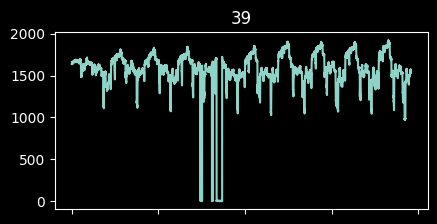

In [ ]:
# range_ = range(7400,8200)
range_ = range(df_with_diff_and_gesture.shape[0])
COLLS = ['39']
# Предполагаем, что gestures - это DataFrame, а OMG_CH - это список с 50 колонками
fig, axes = plt.subplots(10, 5, figsize=(20, 20), sharex=True, sharey=True)

# Преобразуем 2D массив осей в 1D массив для удобства
axes = axes.flatten()

for i, column in enumerate(COLLS):
    axes[i].plot(df_with_diff_and_gesture[column].values[range_])
    axes[i].set_title(column)

# Удаляем лишние подграфики, если их меньше 50
for j in range(len(COLLS), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [ ]:
df_with_diff_and_gesture[(df_with_diff_and_gesture['39'] < 100)][['step','39']]

step  39
7428   134   2
7429   135   0
7430   135   1
7509   136   2
7510   136   2
...    ...  ..
8671   158   1
8672   158   1
8673   158   2
8674   158   0
8675   158   2

[378 rows x 2 columns]

In [ ]:

# Создаем фигуру
fig = go.Figure()

# Для каждой колонки добавляем линию
for column in COLLS:
    fig.add_trace(go.Scatter(
        x=df_with_diff_and_gesture['step'].values[range_],
        y=df_with_diff_and_gesture[column].values[range_],
        mode='lines',
        name=column
    ))

# Настройка оформления и разметки
fig.update_layout(
    title="Plot for Columns with SYNC as X-axis",
    xaxis_title="step",
    yaxis_title="Values",
    height=600,
    width=800
)

# Отображение графика
fig.show()

In [ ]:
df_with_diff_and_gesture[df_with_diff_and_gesture.gesture == 0][['step','39']]

step    39
0         1  1639
1         1  1650
2         1  1641
3         1  1651
4         1  1645
...     ...   ...
19563   361  1532
19564   361  1535
19565   361  1539
19566   361  1536
19567   361  1533

[12659 rows x 2 columns]

In [ ]:
grouped_step = df_with_diff_and_gesture[df_with_diff_and_gesture.gesture == 0][['step','39']].groupby('step')['39'].apply(lambda x: x.to_numpy())
# grouped_step

In [ ]:
flattened_vectors.__len__()

211